# Time Series Analysis Individual Project

# **Analyzing Cinema Occupancy Rates: A Time Series Forecasting Study.**

### **Abstract**

Entertainment venues, including cinemas, often suffer from the challenge of high costs and resource wastage due to uncertainties in attendance. This study focuses particularly on addressing these issues by analyzing the occupancy rate in cinema screenings and its high impact on the total sales. By leveraging estimated future values based on time series analysis techniques and comprehensive modeling using **$ARIMA$** models, cinemas can optimize ticket pricing strategies for different days, periods and seasons, thereby reducing costs and maximizing profits. The findings of this research in occupancy rate hold the potential to significantly enhance operational efficiency and financial performance for cinemas in particular and entertainment facilities in general.

### **Introduction**

To fulfill the main goal of this work. We will be using the dataset in `cinema.csv` that holds daily information about the total sales and occupancy rate captured from several cinemas across several months. Precisely, from March to November of 2023. Total Sales is the average total sales of all the movie theaters in the sample per each day. The occupancy rate or percentage, defines the average of the total number of sold tickets to the maximum capacity of each cinema hall (movie theater) per each day as well. These two features are the most important for this study.  
Note that the time series dataset was drawn from **Kaggle**. A competition platform and Online Community of data scientists where we can find and publish open datasets. Here is the link: https://www.kaggle.com/datasets/arashnic/cinema-ticket. Of course, in order to be able to conduct the study, we already grouped the data by the **mean** of occupancy rates and total sales for all cinemas to get one representative value per day.

### **Analysis & Model Specification**

#### **Data Exploration**

Our dataset has two main features alongside date. The first one is `total_sales` and the other one is `occu_perc` (occupancy rate). As stated before, the data is captured on a daily basis for several months during 2023.  
We start by importing our data which is stored inside the folder `data`, and then separate, for each column, into a time series data using `ts` function giving it frequency of **1** since our data is daily based data:

In [1]:
# install the needed libraries in case you do not have them or you opened this notebook in Google Colab
install.packages("forecast", repos="https://cloud.r-project.org/", quiet=TRUE)
install.packages("MASS", repos="https://cloud.r-project.org/", quiet=TRUE)
install.packages("tseries", repos="https://cloud.r-project.org/", quiet=TRUE)
install.packages("leaps", repos="https://cloud.r-project.org/", quiet=TRUE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# loading required packages
library(forecast)
library(MASS)
library(tseries)
library(leaps)

# importing the data
data = read.csv('data/cinema_daily.csv')
data$date = as.Date(data$date)
ts_occu = ts(data$occu_perc, frequency = 1)
ts_sales = ts(data$total_sales, frequency = 1)
print(ts_occu)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Time Series:
Start = 1 
End = 232 
Frequency = 1 
  [1] 11.457937 16.925195 17.678305 13.620901 11.631185 11.348382  5.481456
  [8] 23.086211 19.826853 24.670227 29.649734 28.242404 29.556097 43.831265
 [15] 36.181408 34.507889 36.284120 35.476508 38.772810 30.263839 47.649573
 [22] 26.569331 34.293851 35.759211 16.869375 16.363449 16.911276 55.011650
 [29] 25.956113 37.413126 41.257182 35.582667 15.630738 15.817802 53.415291
 [36] 27.748966 34.396651 36.306576 18.327360 16.869954 17.060684 54.235684
 [43] 25.509064 32.822085 33.684267 18.410508 16.970639 15.867369 45.758699
 [50] 30.808104 28.757890 29.315020 15.349698 13.635261 13.879240 45.293380
 [57] 18.612105 25.576150 28.412918 15.361599 13.186189 12.823135 43.356345
 [64] 17.496215 22.078675 26.656444 13.232664 13.534727 12.739496 35.841278
 [71] 16.965662 21.806707 23.191332 12.757884 11.871983 12.085180 29.623782
 [78] 13.584040 17.851189 21.159873 12.610793 14.147056 96.637500 14.475494
 [85] 14.696479  8.874851  8.689119  8

And before starting the work on occu_perc, let us plot its correlation with the total sales:

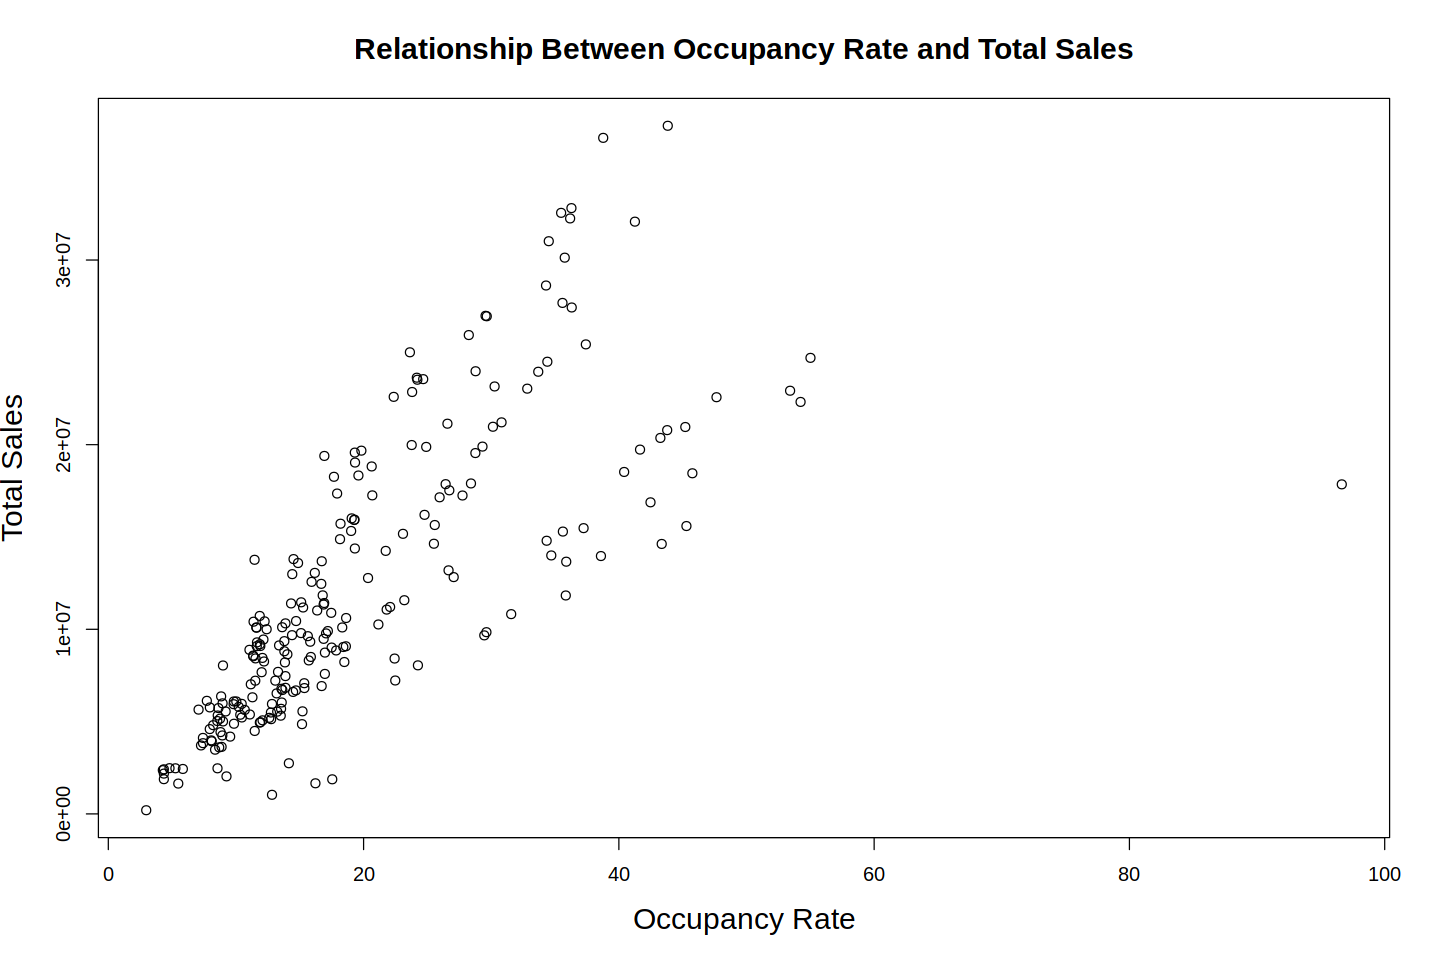

In [3]:
# adjust the width and height of the plot
options(repr.plot.width = 12, repr.plot.height = 8) 

# adjust the labels sizes
par(cex.lab = 1.8, cex.main = 1.8)

# plot the correlation
plot(data$occu_perc, data$total_sales,
     xlab = 'Occupancy Rate', ylab = 'Total Sales',
     main = 'Relationship Between Occupancy Rate and Total Sales',
     cex.lab = 1.5,
     cex.main = 1.5)

As proven, there is a **positive correlation** between the two features. As the occupancy rate increases, sales are increasing.

Now, we plot the occupancy rate to try to determine its components:

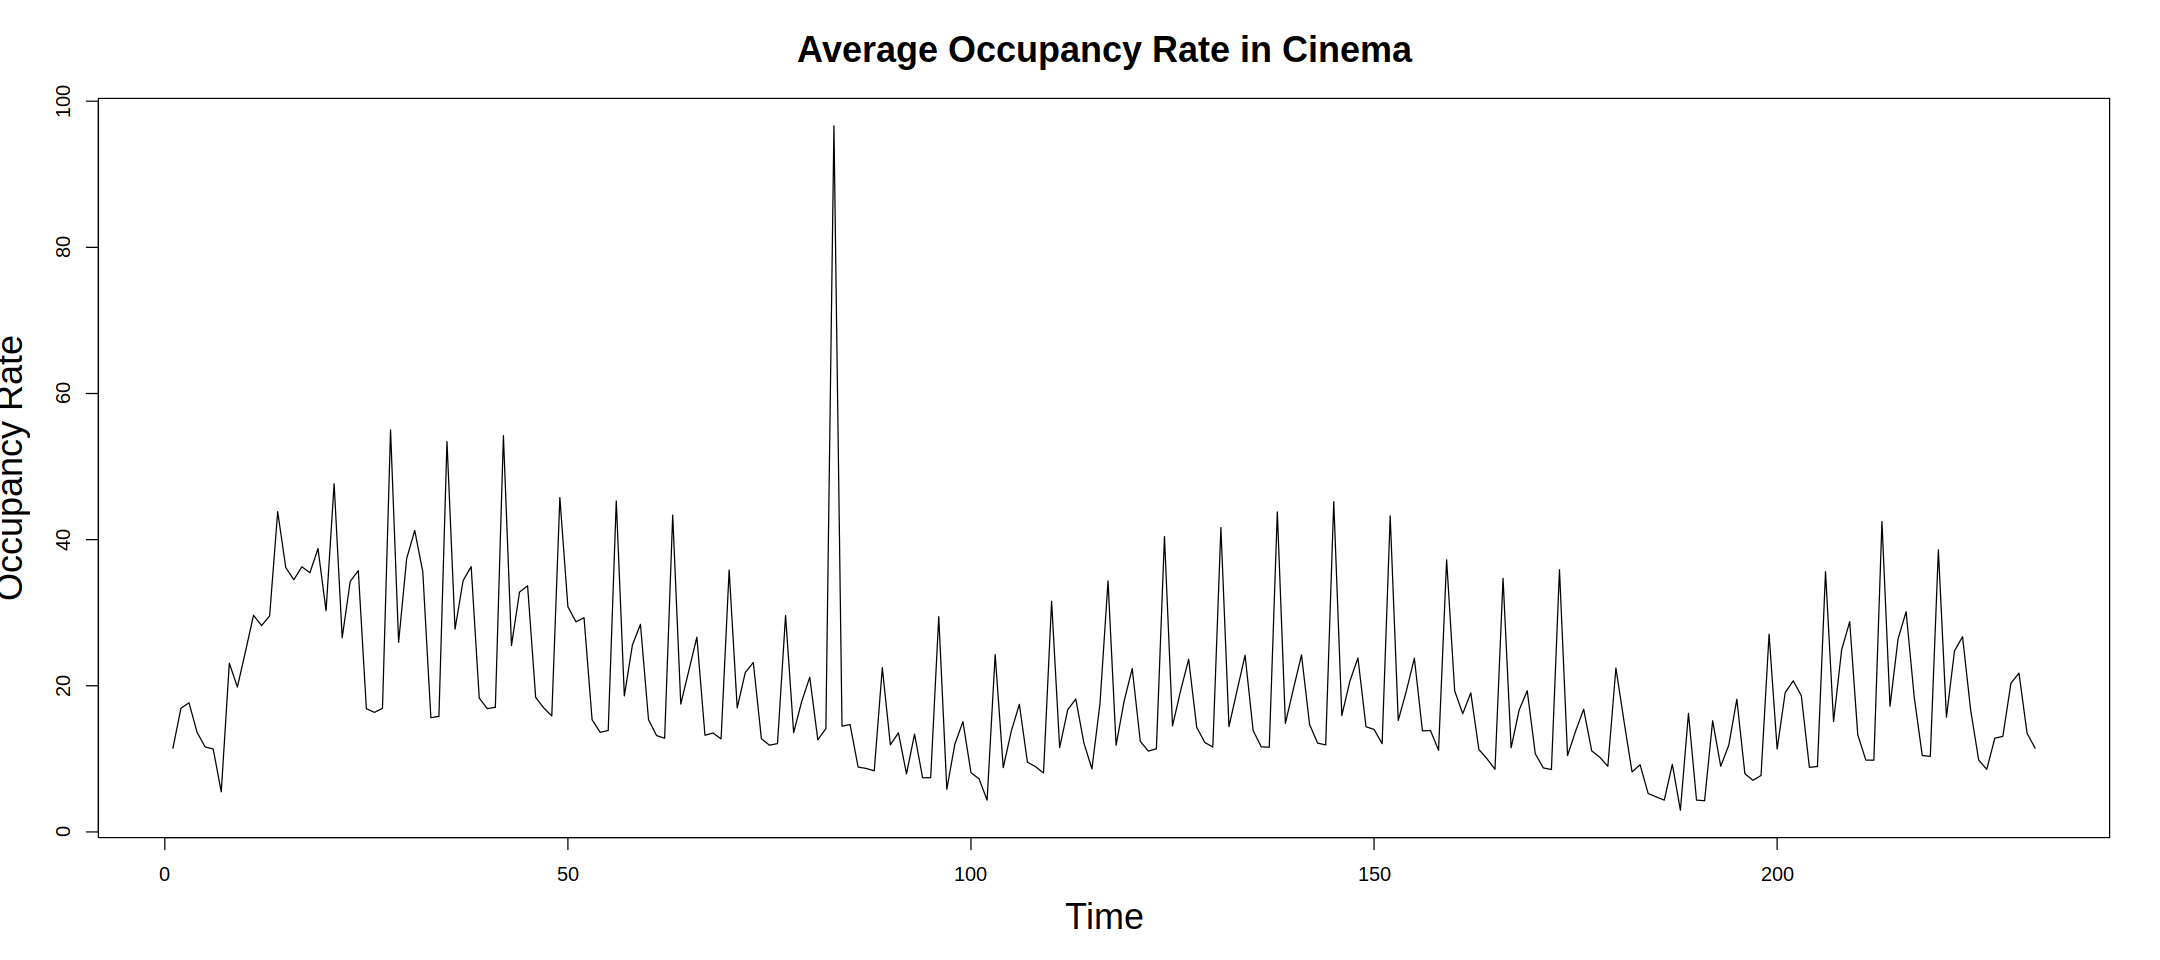

In [4]:
# width and height
options(repr.plot.width = 18, repr.plot.height = 8)

# adjust the labels sizes
par(cex.lab = 1.8, cex.main = 1.8)

# lineplot the time series
plot(ts_occu,
     type ='l', xlab='Time', 
     ylab ='Occupancy Rate',
     main = 'Average Occupancy Rate in Cinema')

From the plot, it is hard to determine a long-term **trend**. However, it is clear that the occupancy rate is **seasonal**. In order to make things much more perspicuous, we will decompose the data into its components: Trend, Seasonality and Residuals.

#### **Decomposition**

To separate the trend, seasonality and noise components or remainders, we use a technique called **STL decomposition** provided by R as `stl`:

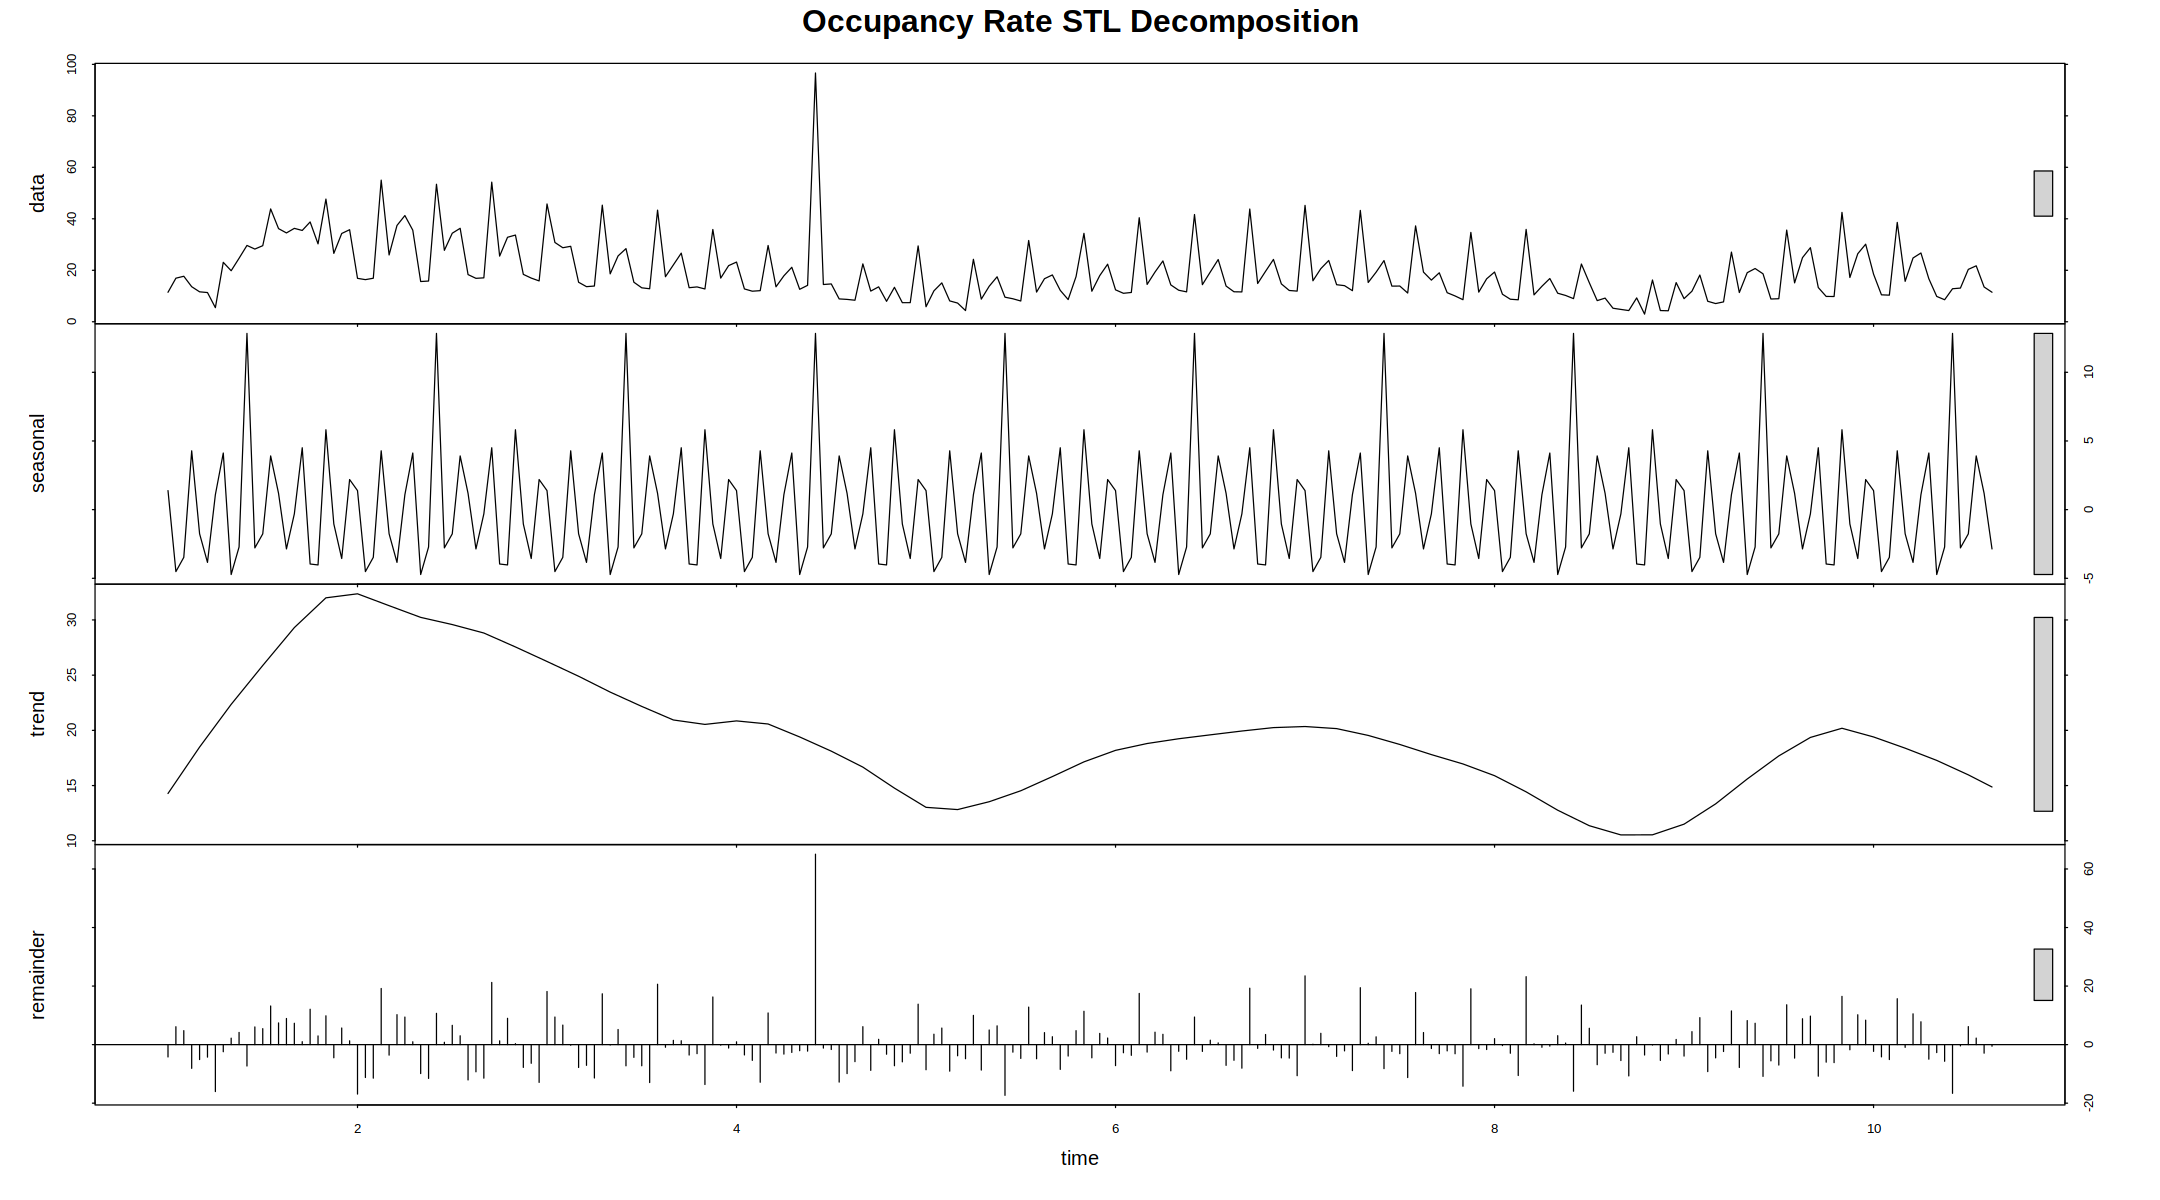

In [5]:
# width and height
options(repr.plot.width = 18, repr.plot.height = 10)

# adjust the labels sizes
par(cex.lab = 2.4, cex.main = 2.4)

# decomposition using STL
occu_stl_result = stl(ts(data$occu_perc, frequency = 24), s.window = 'periodic')
plot(occu_stl_result,
     main = 'Occupancy Rate STL Decomposition')

The **trend** component reveals minor fluctuations with very small long-term downward movement. On the other hand, the **seasonality** component captures a strong seasonal fluctuation in occupancy rate. Notably, the occupancy rate shows **some randomness**.

#### **Stationarity**

One of the most important features and requirements of data before modeling is that it has to be **stationary**. That means that the **mean** should not be a function of time **$t$** rather should be a constant, the **variance** should not be dependent on time **$t$** and the **covariance** as well should not depend on **$t$** but on the lag **$k$** between the **$i-th$** term and **$(i+k)-th$** term.

To ensure the stationarity of our data, we use several techniques.

#### Stabilizing the Variance

The first one to make the variance constant. It is known as **BoxCox transformation** provided by the **MASS** library. It will give us the **best lambda (λ)** such that the transformed data is close to normally distribution using the formula:
  

\begin{cases}
    T(Y_t) = \frac{{Y_t^\lambda - 1}}{{\lambda}}, & \text{if } \lambda \neq 0 \\  
    T(Y_t) = \log(Y_t), & \text{if } \lambda = 0
\end{cases}



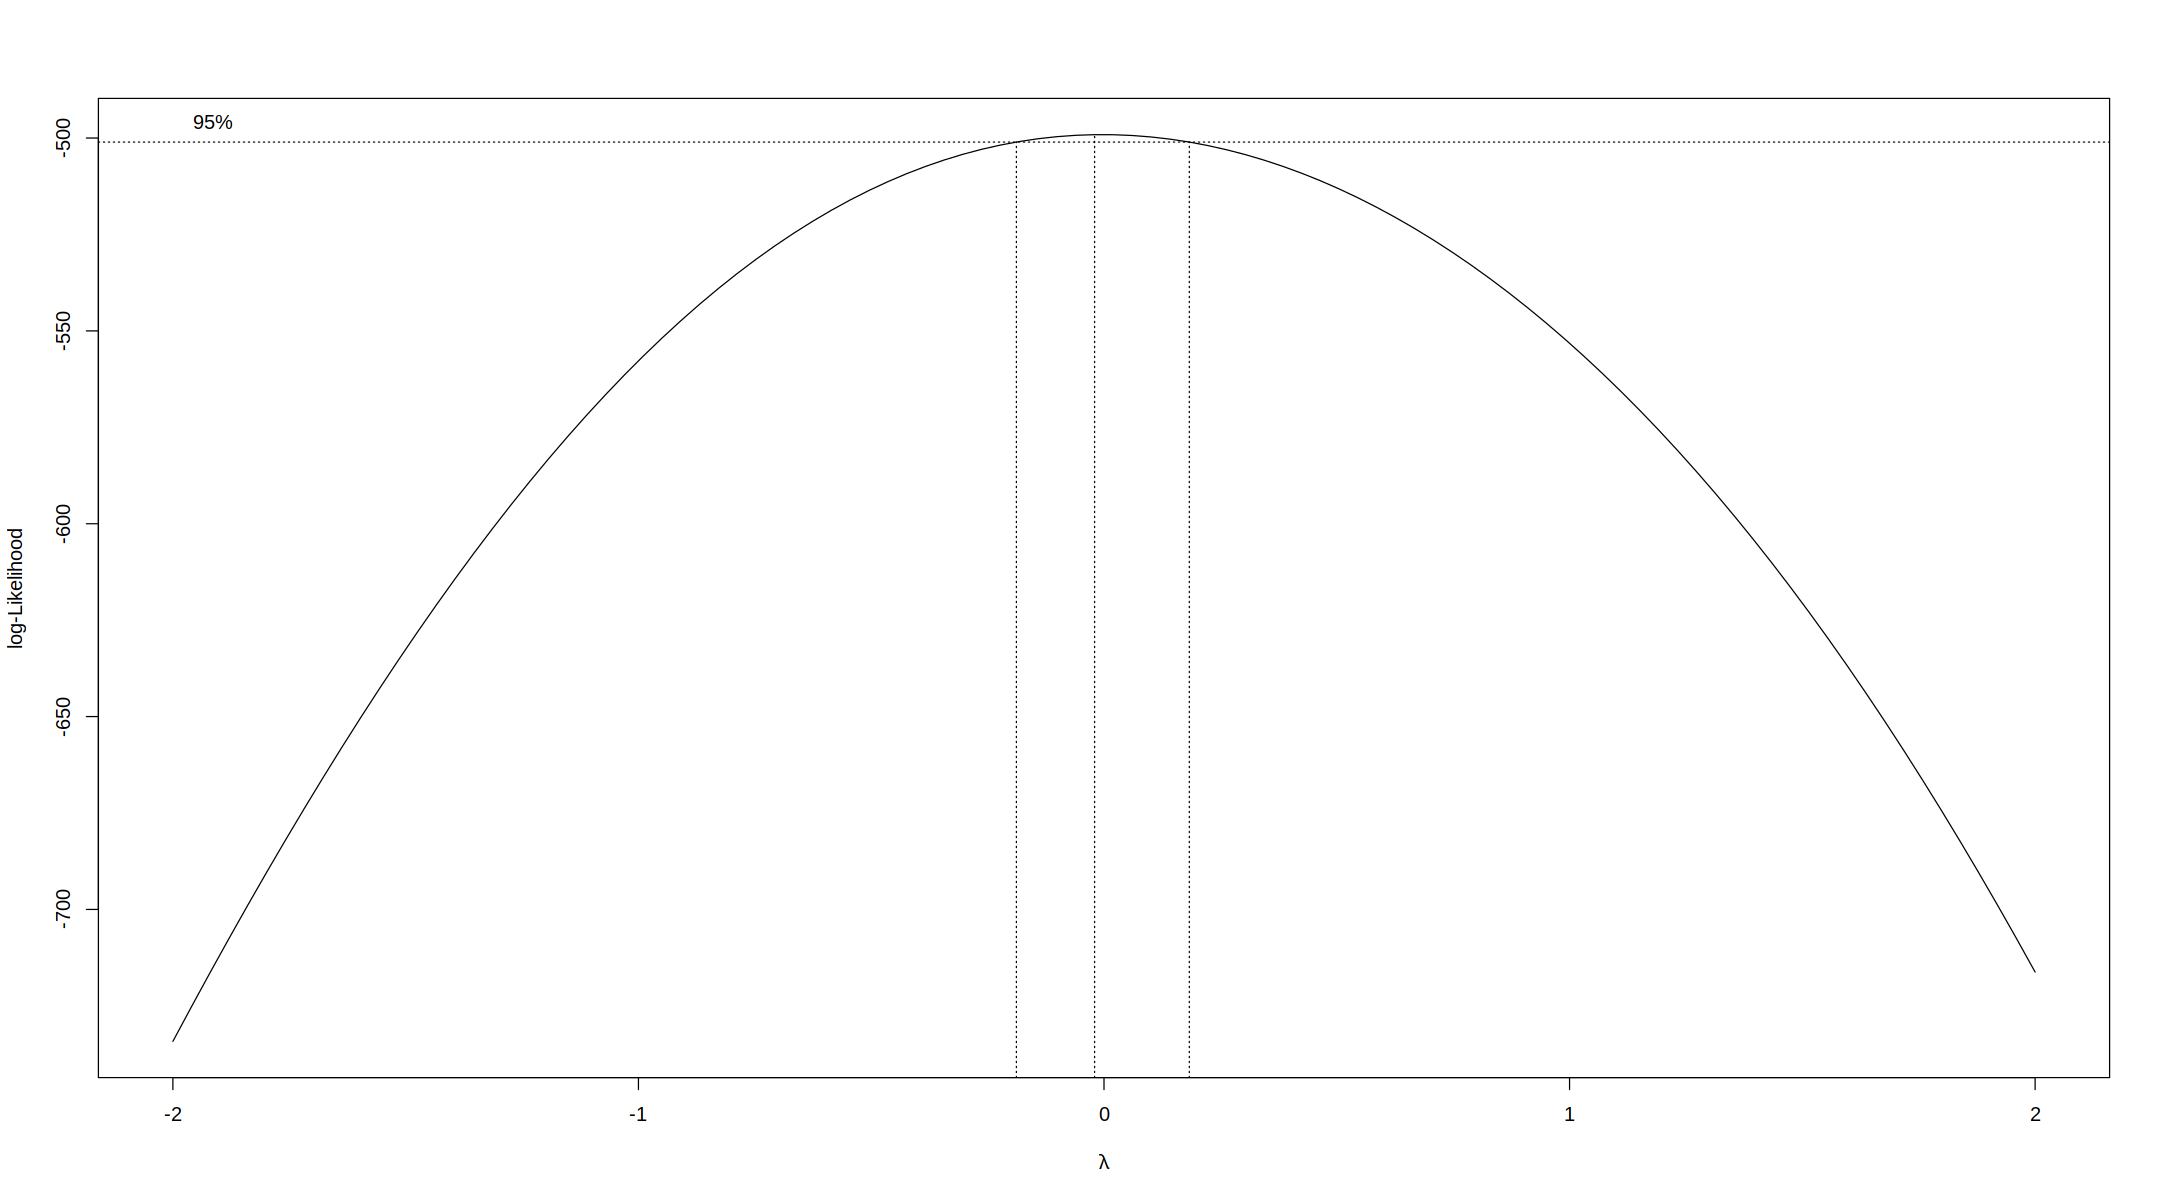

In [6]:
# extract numeric values from the time series
occu_values = as.numeric(ts_occu)

# apply the boxcox transformation
ts_occu_boxcox = boxcox(occu_values ~ 1)

In [7]:
# extract the best lambda value
best_lambda = ts_occu_boxcox$x[which.max(ts_occu_boxcox$y)]
best_lambda

[1] -0.02020202

As seen from the plot and the exact value of **$ \lambda $**, it is really close to 0, so we will assume it zero and then we apply the transformation:

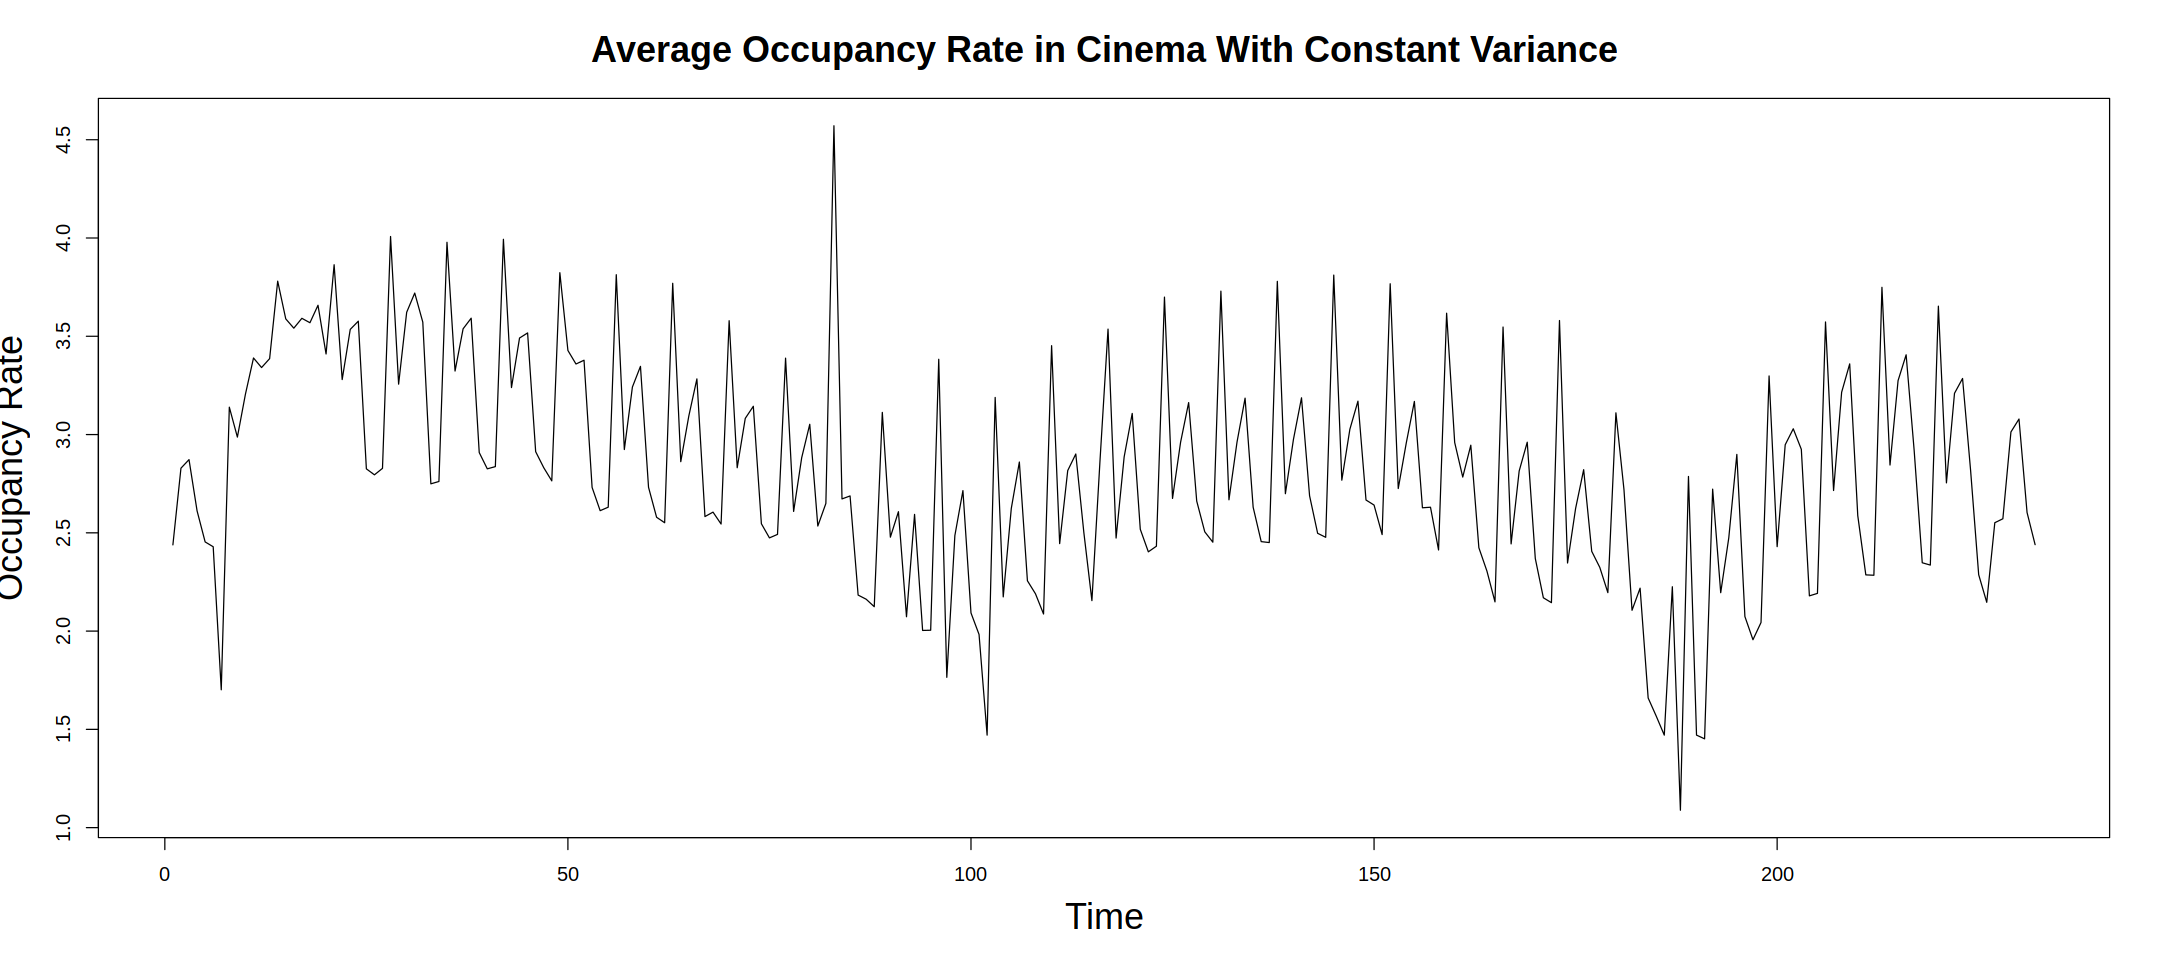

In [8]:
# transform with log(y)
ts_occu_stable_var = log(ts_occu)

# adjust the labels sizes
par(cex.lab = 1.8, cex.main = 1.8)

# re-plot the data
options(repr.plot.width = 18, repr.plot.height = 8) 
plot(ts_occu_stable_var,
     type ='l', xlab='Time', 
     ylab ='Occupancy Rate',
     main = 'Average Occupancy Rate in Cinema With Constant Variance')

#### Differencin: Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

To confirm the need of **dfferencing**. We plot the **Sample Autocorrelation Function** and **Partial Autocorrelation Function**. the **ACF** calculate the autocorrelation function between **$Yt$** and its $k-th$ lag **$Yt-k$**. Meanwhile, **PACF** measures the same relationships after removing the effects of lags between **$t$** and **$t-k$**, here are the results of the plots on the stabilized data:

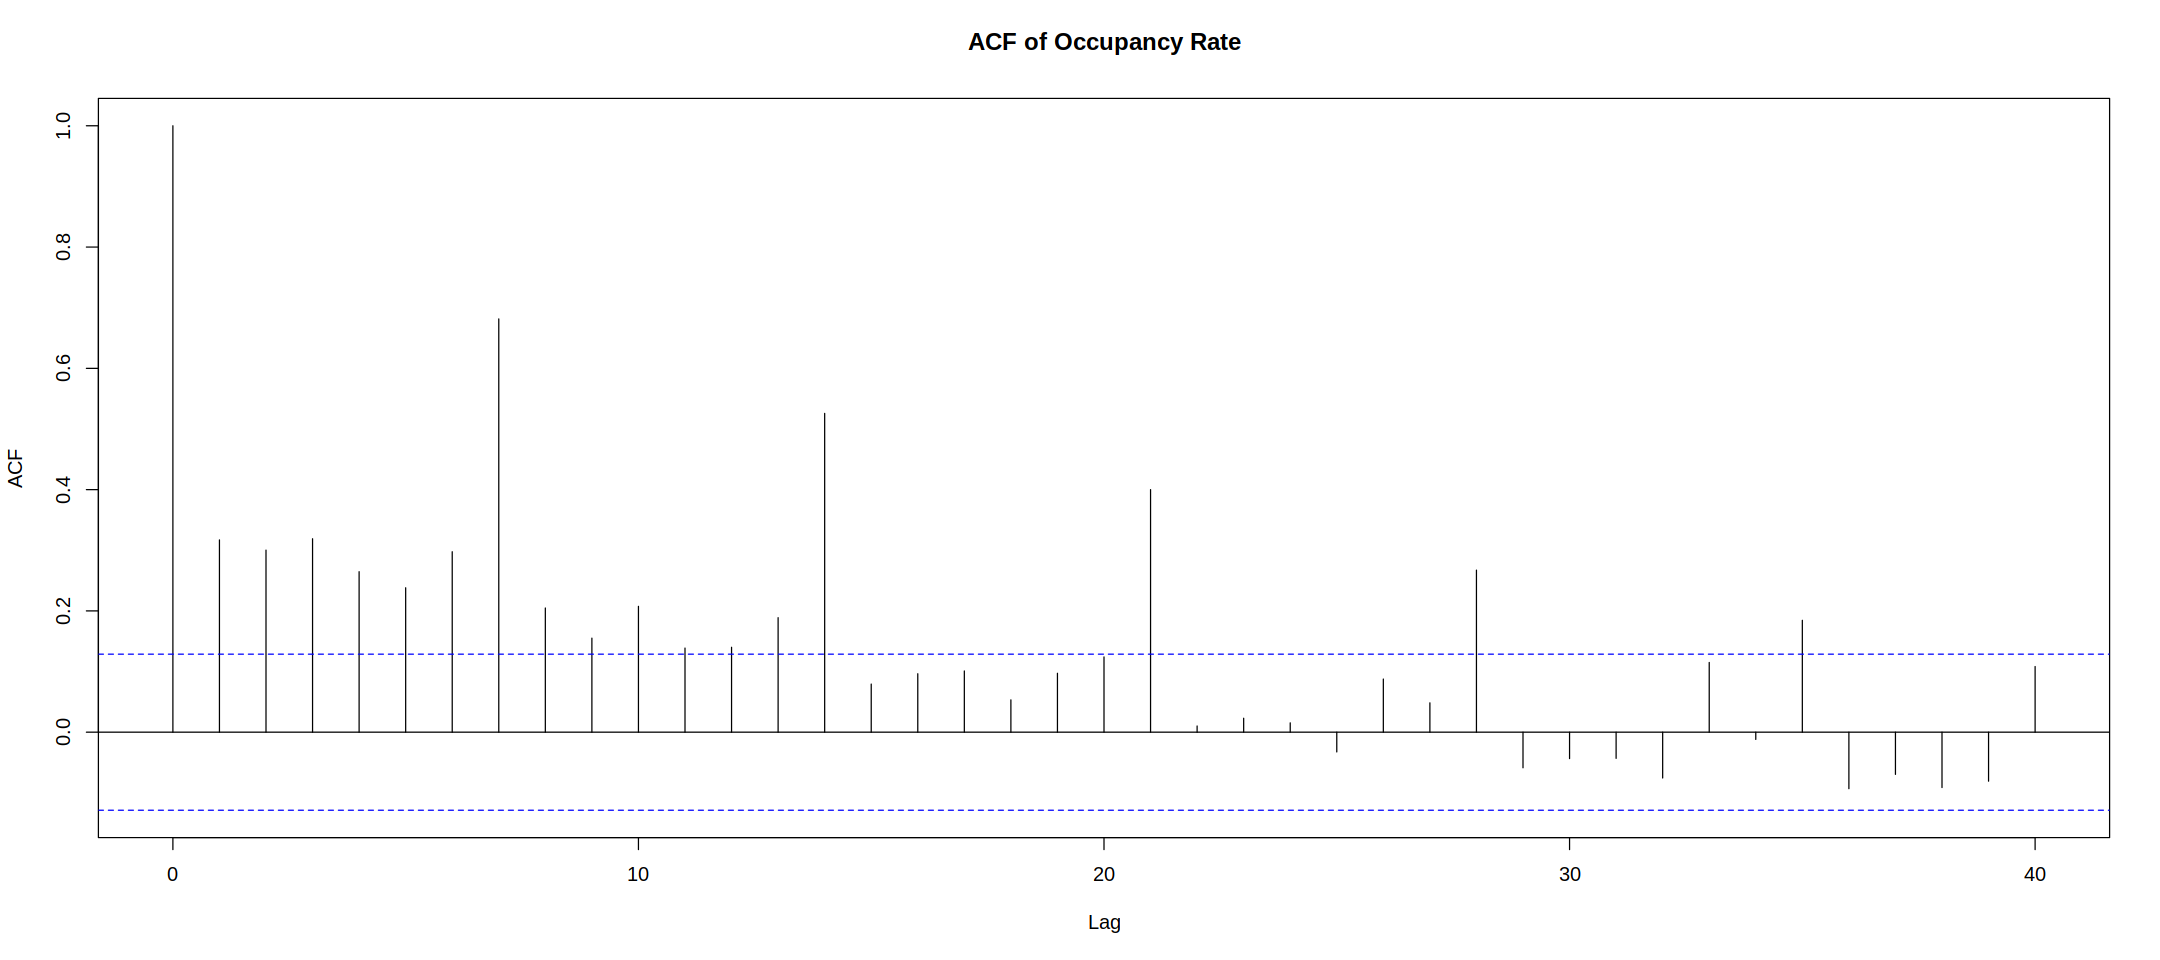

In [9]:
# plot the acf
acf(ts_occu_stable_var, lag.max = 40, main='ACF of Occupancy Rate')

**ACF** is decaying slowly signifying that the data requirs differencing. Additionally, Spikes occur each **7** lags indicating seasonality. Thus, we will apply the first order difference **$\nabla Y_t$** on **$Y_t$**:

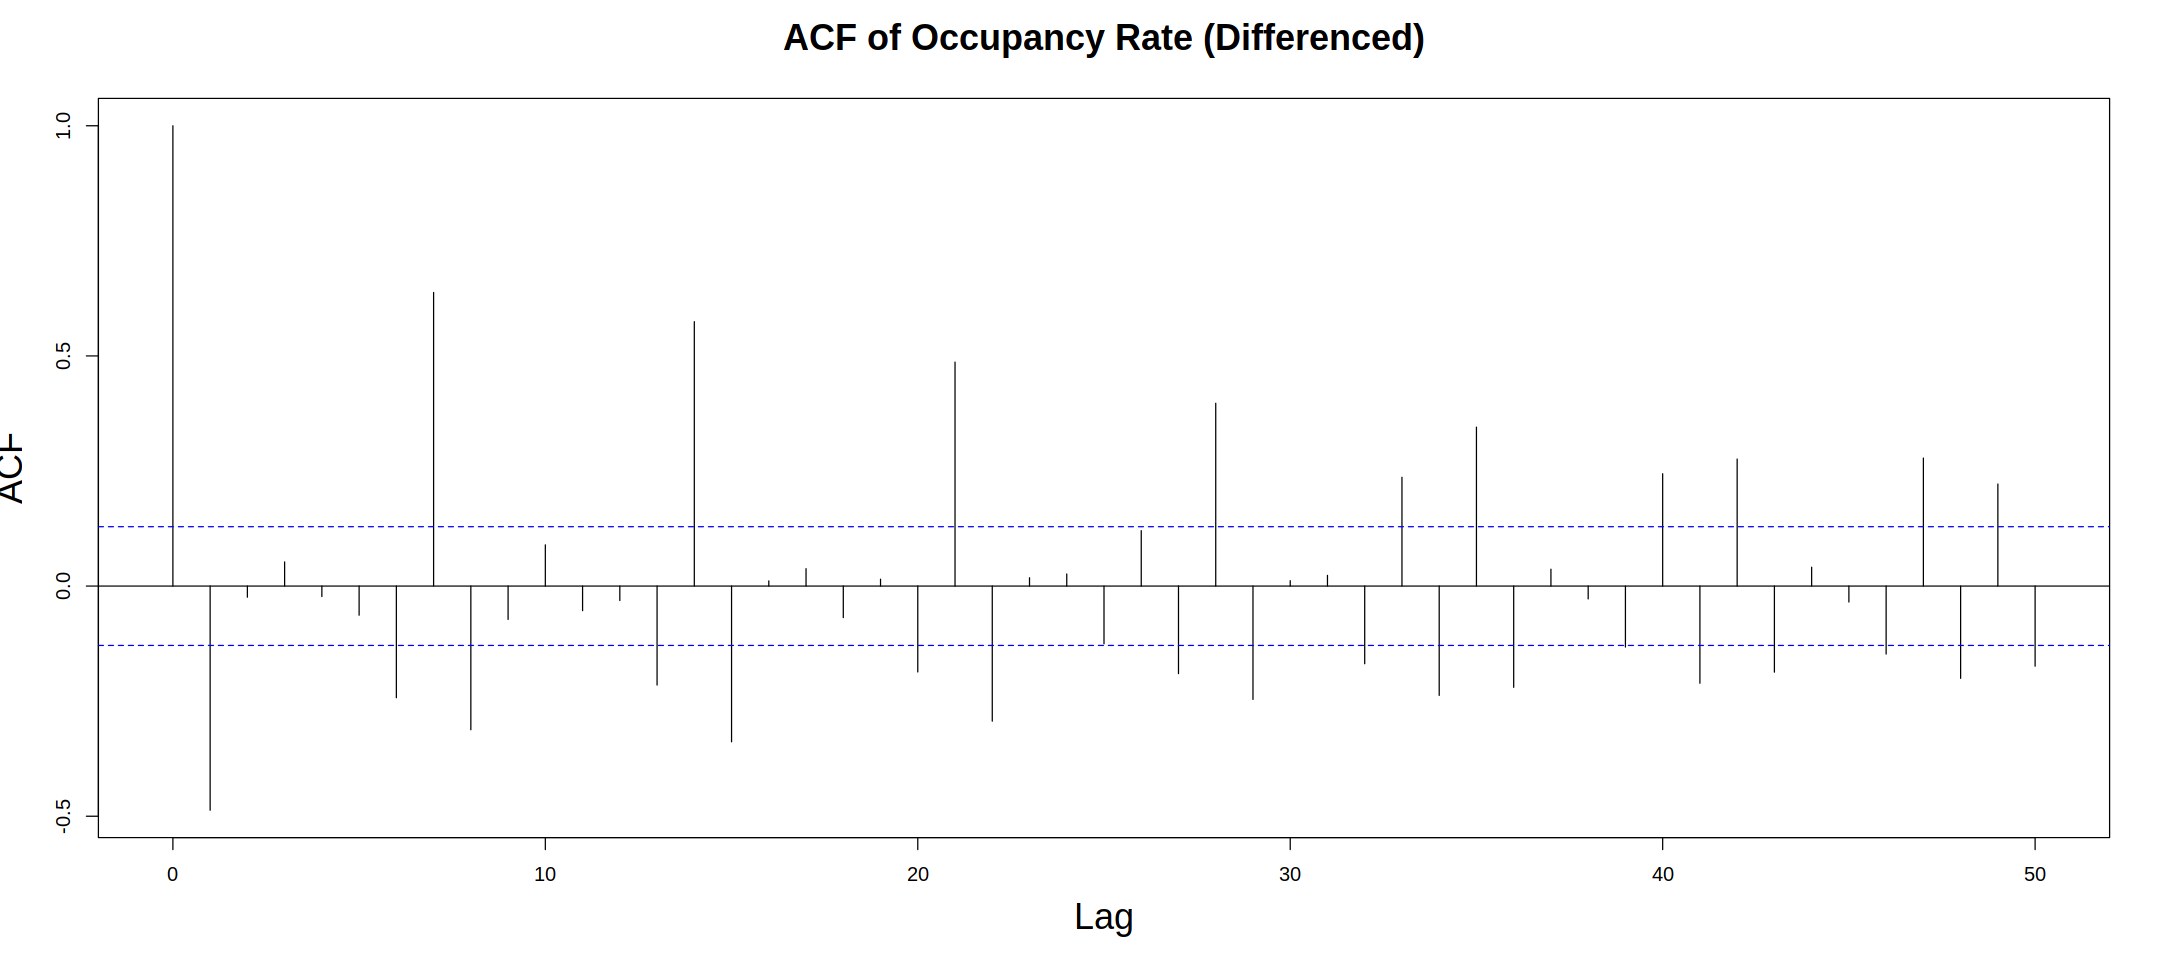

In [10]:
# detrend the data (first order differencing)
detrended_occu = diff(ts_occu_stable_var, lag = 1)

# adjust the labels sizes
par(cex.lab = 1.8, cex.main = 1.8)

# plot the acf
acf(detrended_occu, lag.max = 50, main='ACF of Occupancy Rate (Differenced)')

#### Dickey & Fuller Test for Stationarity

**ACF** itself can be misleading in observing stationarity. For that, we will use the methodology proposed by **Dickey & fuller** to test whether an observed time series is stationary or not. The test goes like:

\begin{align*}
& H_0: \alpha = 1 \quad \text{(nonstationarity)} \\
& H_1: \alpha < 1 \quad \text{(stationarity)}
\end{align*}

In [11]:
# apply adf test on non-difference data
adf.test(ts_occu_stable_var)


	Augmented Dickey-Fuller Test

data:  ts_occu_stable_var
Dickey-Fuller = -2.6179, Lag order = 6, p-value = 0.3163
alternative hypothesis: stationary


In [12]:
# apply adf test on differenced data (detrended using first difference)
adf.test(detrended_occu)

Warning message in adf.test(detrended_occu):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  detrended_occu
Dickey-Fuller = -9.7238, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


As noticeable, the **ADF** test states to us that **${Y_t}$** is **nonstationary**. However, **$\nabla Y_t$** is **stationary**.  
Yet, the test is not really that informative because a different form of nonstationarity may occur.

#### Conclusion of Model Specification

As a conclusion of this section, and based on the nature of our data alongside the autocorrelation function plot and tests, we suggest an **$ARIMA(p, d, q)$** model for it. The steps of fitting its parameters **$p$**, **$d$** and **$q$** are the next step.

### **Fitting & Model Diagnostics**

#### **Best Model Parameters**

Now, we will use some techniques in order to detect the best parameters **$p$**, **$d$** and **$q$** for the **$ARIMA$** model.

#### Train-Test Split

First of all, let us split our data into **train (90%)** and **test (10%)**:

In [13]:
train_length = round(length(ts_occu_stable_var) * 0.9)

# split
train = window(ts_occu_stable_var, end = train_length)
test = window(ts_occu_stable_var, start = train_length + 1)

cat('Length of train: ', length(train), '\n')
cat('Length of test: ', length(test), '\n')

Length of train:  209 
Length of test:  23 


#### Model Fitting: ACF & PACF

The first method to check for the orders of the **$AR$** and **$MA$** parts of our **$ARIMA$** model is **ACF** and **PACF** plots again:

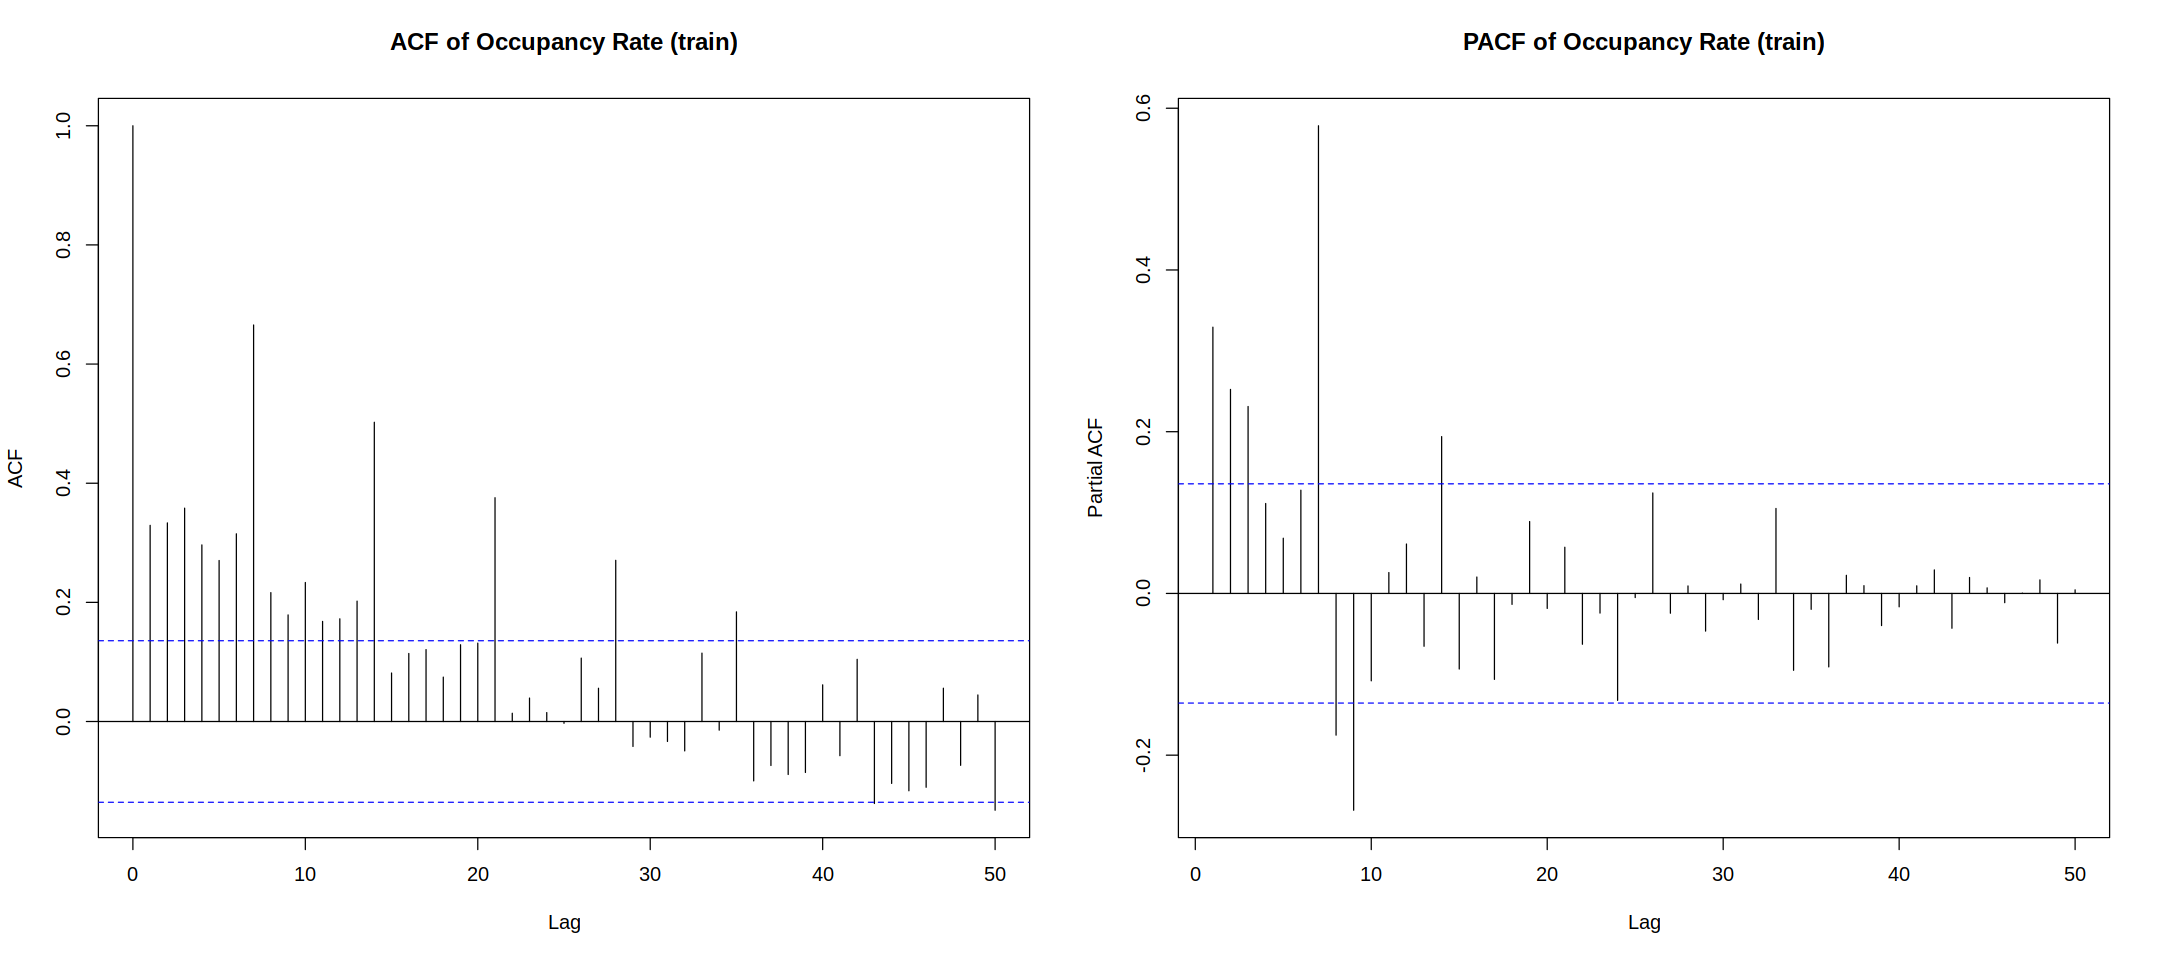

In [14]:
par(mfrow = c(1, 2))

# plot the acf
acf(train, lag.max = 50, main='ACF of Occupancy Rate (train)')
# plot the pacf
pacf(train, lag.max = 50, main='PACF of Occupancy Rate (train)')

* The **ACF** suggests that there is a significant autocorrelation at multiples of the seasonal period indicating the seasonal pattern. Additionally, the need of differencing, **$d \neq 0$**.
* the **PACF** shows significant partial autocorrelation at the first few lags (up to eight lags). Then, it decreases and remains within the confidence interval indicating that the autocorrelation diminishes as the lag increases. It suggests an order **$p \leq 8$**
* Based on the results, we suggest that the appropriate **ARIMA** model for modelling the data is with seasonal and autoregressive components.

#### Model Fitting: Bayesian Information Criterion

The **BIC** aims to select the **$ARMA(p, q)$** model which minimizes:  
\begin {align*}
BIC = -2 \ln L + k \ln n
\end {align*}
* **$L$**: maximized likelihood function.
* **$k$**: number of parameters in the model

In [15]:
zlag <-
function (x, d = 1) 
{
    if (d != as.integer(d) || d < 0) 
        stop("d must be a non-negative integer")
    if (d == 0) 
        return(x)
    else return(c(rep(NA, d), rev(rev(x)[-(1:d)])))
}

armasubsets <-
function (y, nar, nma, y.name = "Y", ar.method = "ols", ...) 
{
    lab = NULL
    if (nar > 1) 
        lab = c(lab, paste(y.name, 1:nar, sep = "-lag"))
    if (nma > 1) 
        lab = c(lab, paste("error", 1:nma, sep = "-lag"))
    res.ar = ar(y, method = ar.method)
    resid = res.ar$resid
    x = NULL
    if (nar > 1) {
        for (i in 1:nar) {
            x = cbind(x, zlag(y, d = i))
        }
    }
    if (nma > 1) {
        for (j in 1:nma) {
            x = cbind(x, zlag(resid, d = j))
        }
    }
    x = na.omit(cbind(y, x))
    y = x[, 1]
    x = x[, -1]
    x = data.frame(x)
    colnames(x) = lab
    regobj = regsubsets(y ~ ., data = x, ...)
    class(regobj) = c("armasubsets", "regsubsets")
    invisible(regobj)
}

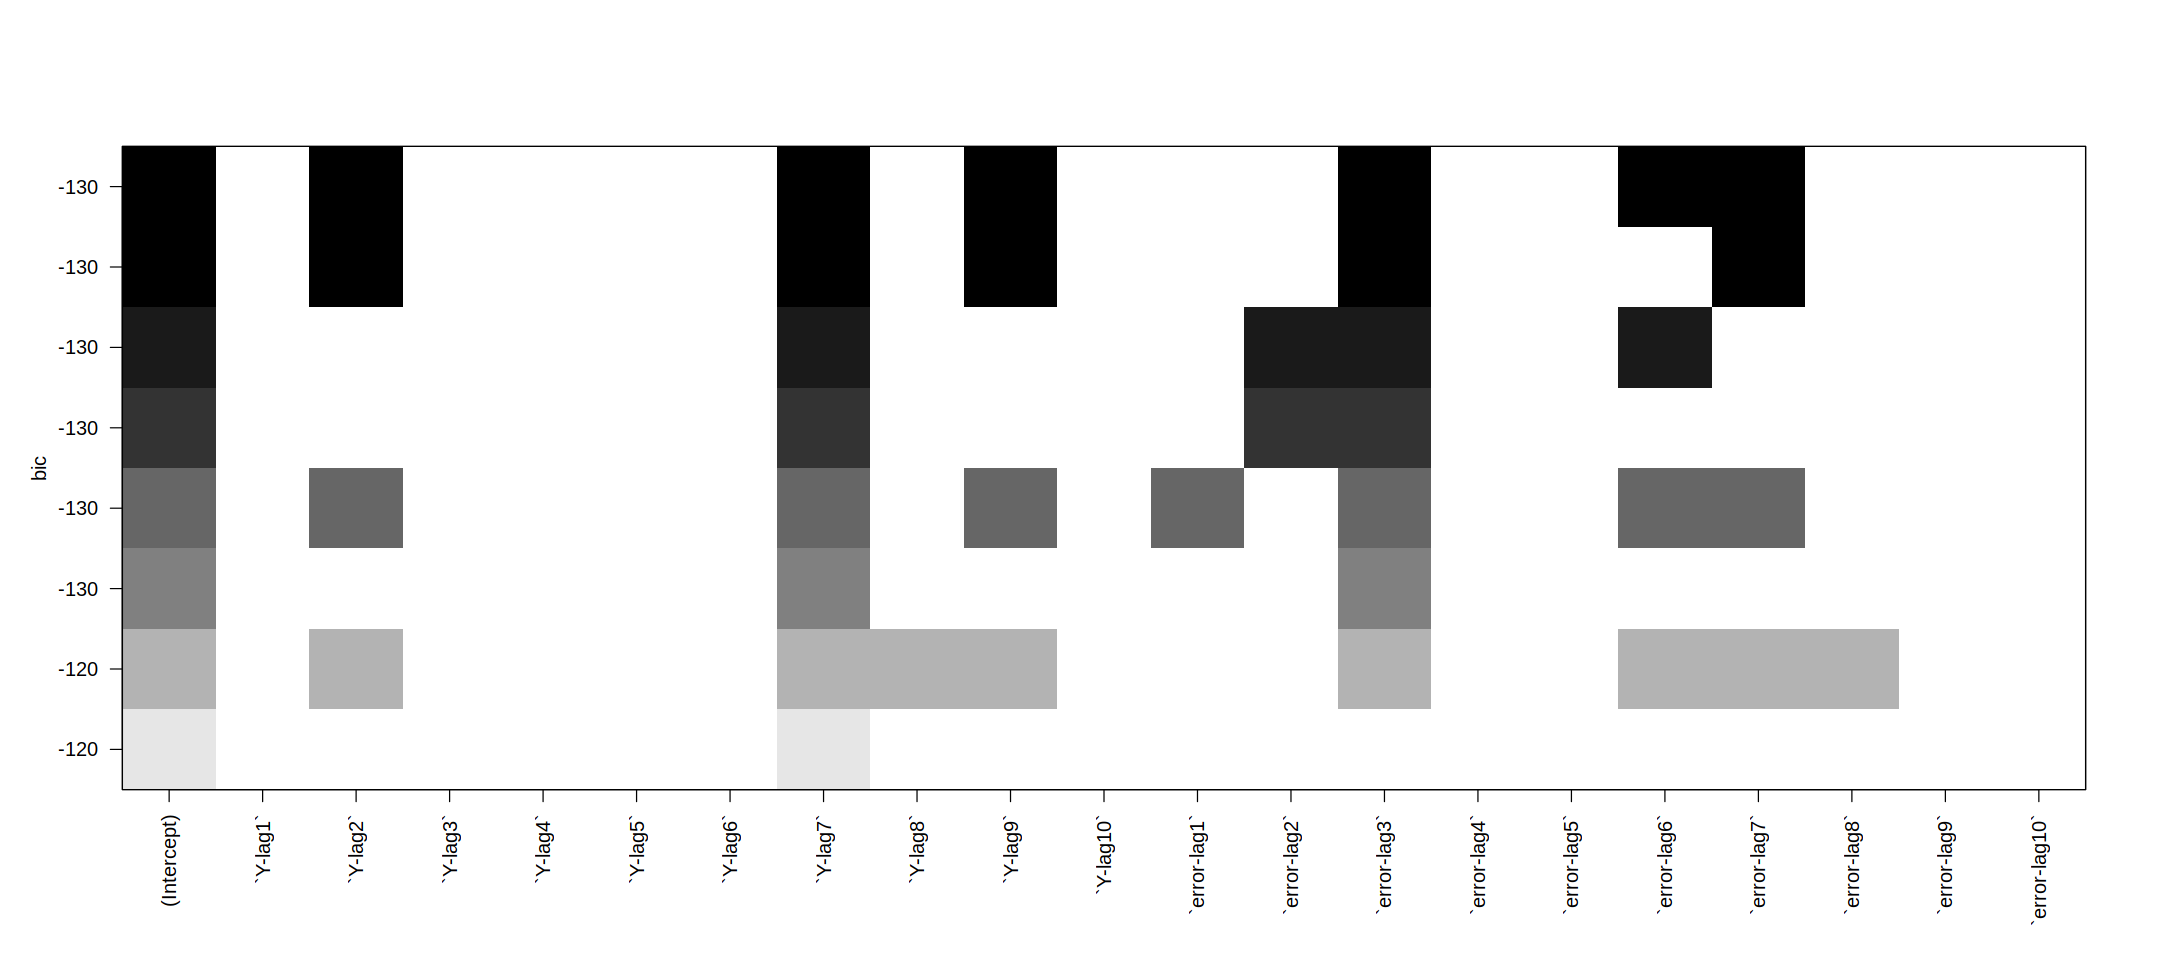

In [16]:
plot(armasubsets(train, 10, 10))

So, the **armasubsets** plot indicates that the following are all possible models:  
**$AR(2)$**, **$AR(7)$**, **$AR(9)$**.  
**$MA(3)$**, **$MA(6)$**, **$MA(7)$**.  
Thus, a combination of them is the potential fit model for our study:  
**$ARMA(2, 3)$**, **$ARMA(2, 6)$**, **$ARMA(2, 7)$**, **$ARMA(7, 3)$**, **$ARMA(7, 6)$**, **$ARMA(7, 7)$**, **$ARMA(9, 3)$**, **$ARMA(9, 6)$**, **$ARMA(9, 7)$**.

In [17]:
# ranges for p, d and q
p_values = 0:10
d_values = 0:2
q_values = 0:10

# store optimal p, d, q values for BIC
optimal_p_bic <- NULL
optimal_d_bic <- NULL
optimal_q_bic <- NULL

# store minimum BIC values
min_bic <- 2000

# iterate over each combination of p, d, and q
for (i in 1:length(p_values)) {
  for (j in 1:length(d_values)) {
    for (k in 1:length(q_values)) {
      # fit ARIMA model using auto.arima
      arima_model = auto.arima(train, d = d_values[j], D = 1, start.p = p_values[i], max.p = p_values[i], start.q = q_values[k], max.q = q_values[k], seasonal = FALSE)
      
      # Calculate BIC
      bic <- BIC(arima_model)
        
      # Update optimal p, d, q for BIC if necessary
      if (bic < min_bic) {
        min_bic <- bic
        optimal_p_bic <- p_values[i]
        optimal_d_bic <- d_values[j]
        optimal_q_bic <- q_values[k]
      }
    }
  }
}

# print optimal p, d and q
print('Optimal parameters based on BIC:')
print(paste('p =', optimal_p_bic, ', d =', optimal_d_bic, ', q =', optimal_q_bic))

[1] "Optimal parameters based on BIC:"
[1] "p = 8 , d = 1 , q = 0"


Great, According to **asmasubsets** plot and **BIC** analysis, we select **$ARIMA(8, 1, 7)$** to model our occupancy rate data.  
Note that the cell takes up to two minutes (at most) to run.

### **Forecasting**

At this phase, we build our model, train it and predict the test instances. After that, we evaluate its goodness of fit.

#### **Modelling**

#### Building the Model

In [18]:
# defining the model
p = 8
d = 1
q = 7

# modelling
arima_model = arima(train, order = c(p, d, q))

# summary statistics
summary(arima_model)


Call:
arima(x = train, order = c(p, d, q))

Coefficients:
          ar1      ar2      ar3      ar4      ar5      ar6     ar7     ar8
      -0.6272  -0.0873  -0.0822  -0.1044  -0.0055  -0.0139  0.8304  0.4491
s.e.   0.1244   0.0703   0.0754   0.0723   0.0650   0.0632  0.0533  0.1008
          ma1      ma2     ma3      ma4      ma5     ma6      ma7
      -0.1798  -0.3101  0.1264  -0.0657  -0.2926  0.1956  -0.4737
s.e.   0.1236   0.1230  0.0965   0.0942   0.0888  0.1167   0.0963

sigma^2 estimated as 0.1263:  log likelihood = -84.63,  aic = 201.27

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set -0.01058989 0.3544937 0.2492767 -2.252814 9.665562 0.5126691
                   ACF1
Training set -0.0236439

#### **Residuals Analysis Evaluation**

Here, we will run some graphical and analytical tests to evaluate how good our model is by studying the residuals:

#### Graphical Analysis

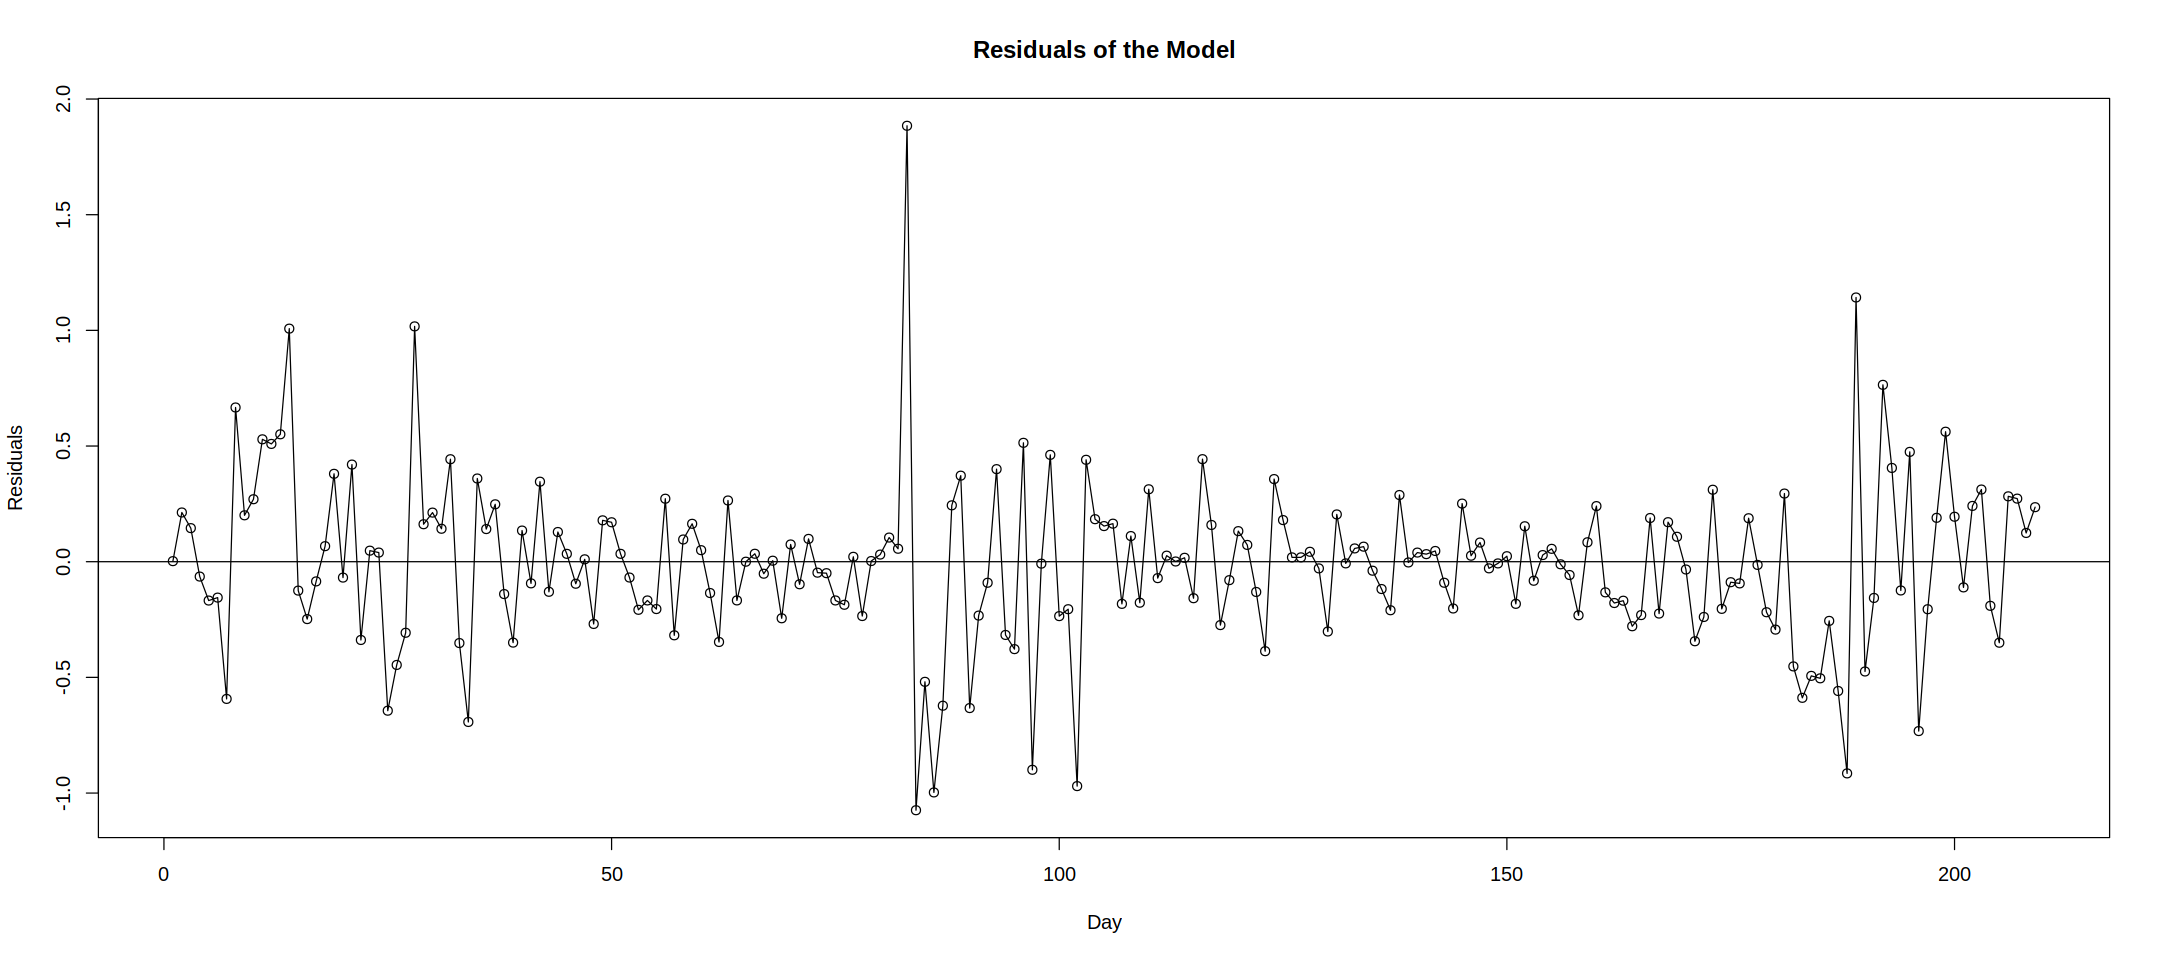

In [19]:
# plot the residuals
plot(residuals(arima_model),ylab='Residuals', main='Residuals of the Model', xlab='Day',type='o')
abline(h=0)

The residuals seem quite like a white noise.

#### Normality

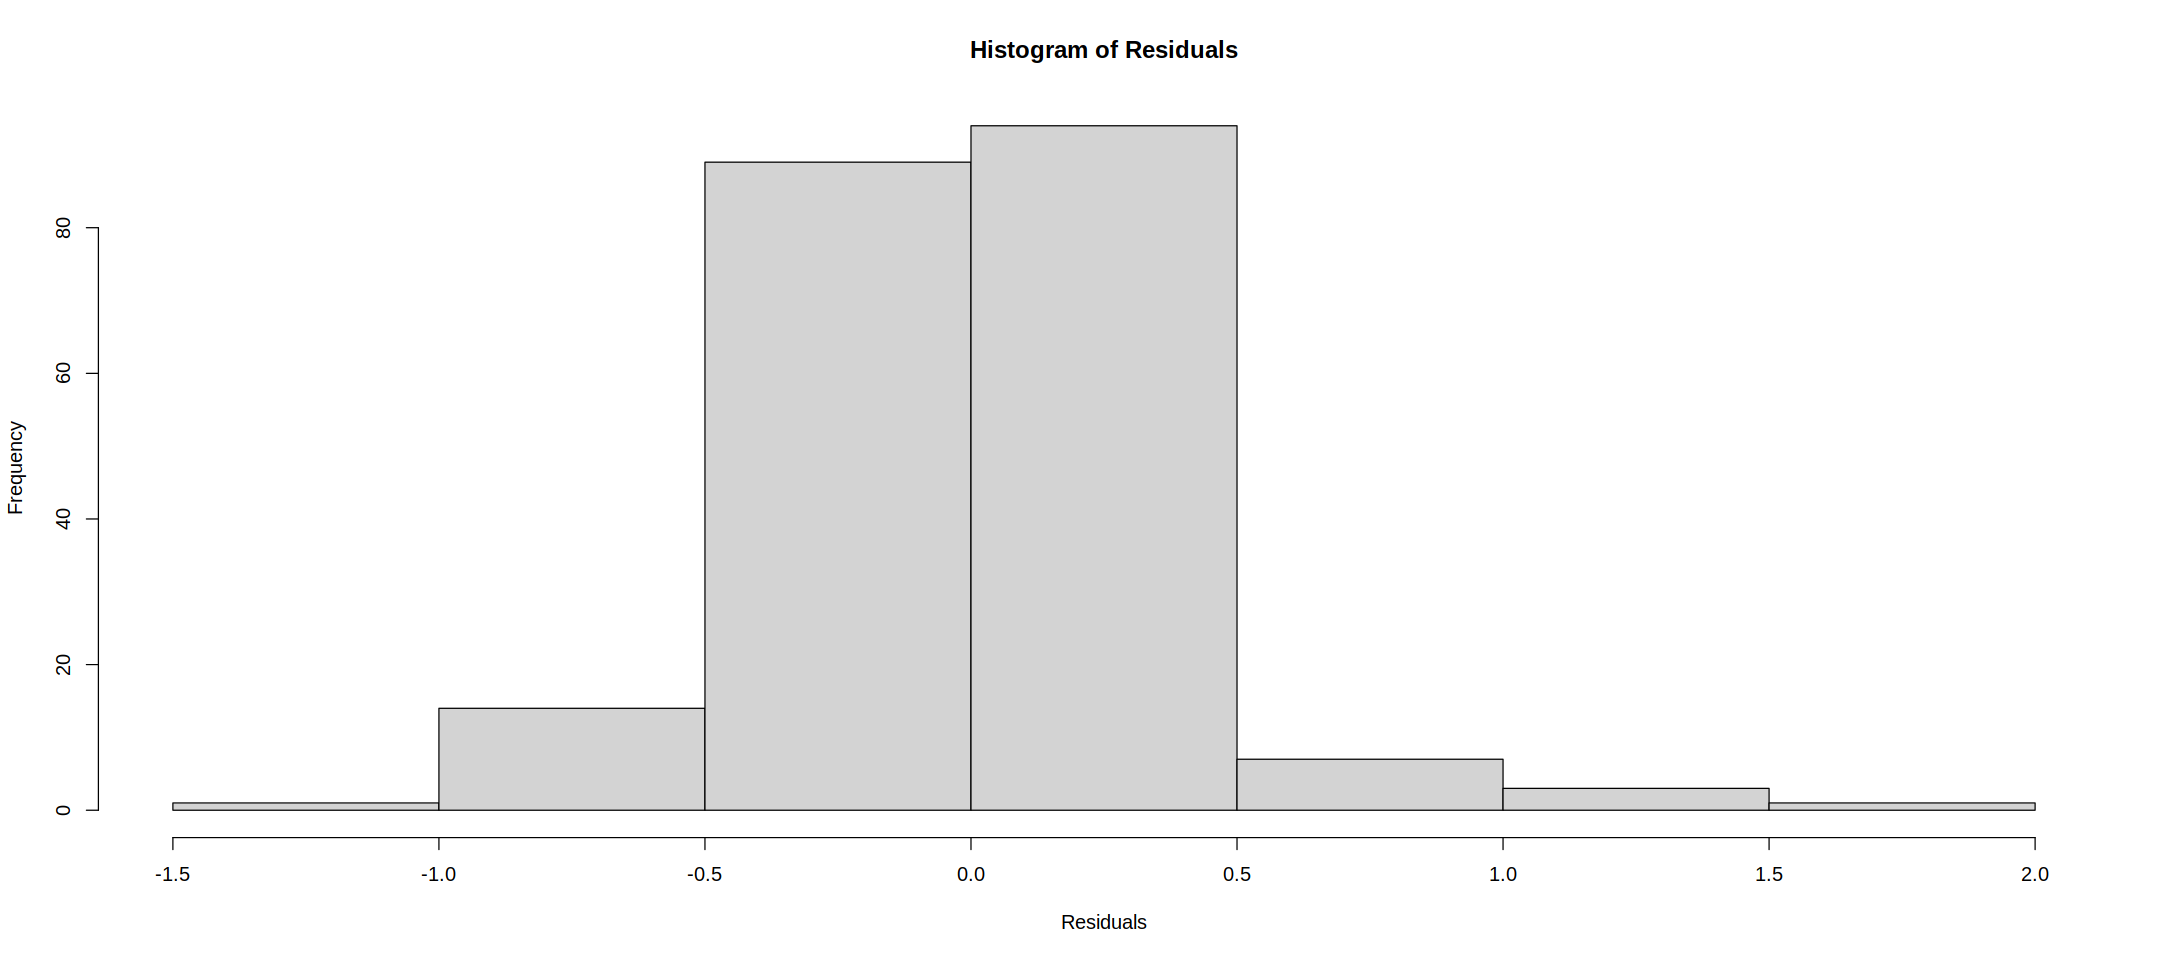

In [20]:
hist(residuals(arima_model),main="Histogram of Residuals",xlab='Residuals')

The residuals seem to be normally distributed. Yet, let us test more because the histogram plots are not so deterministic.

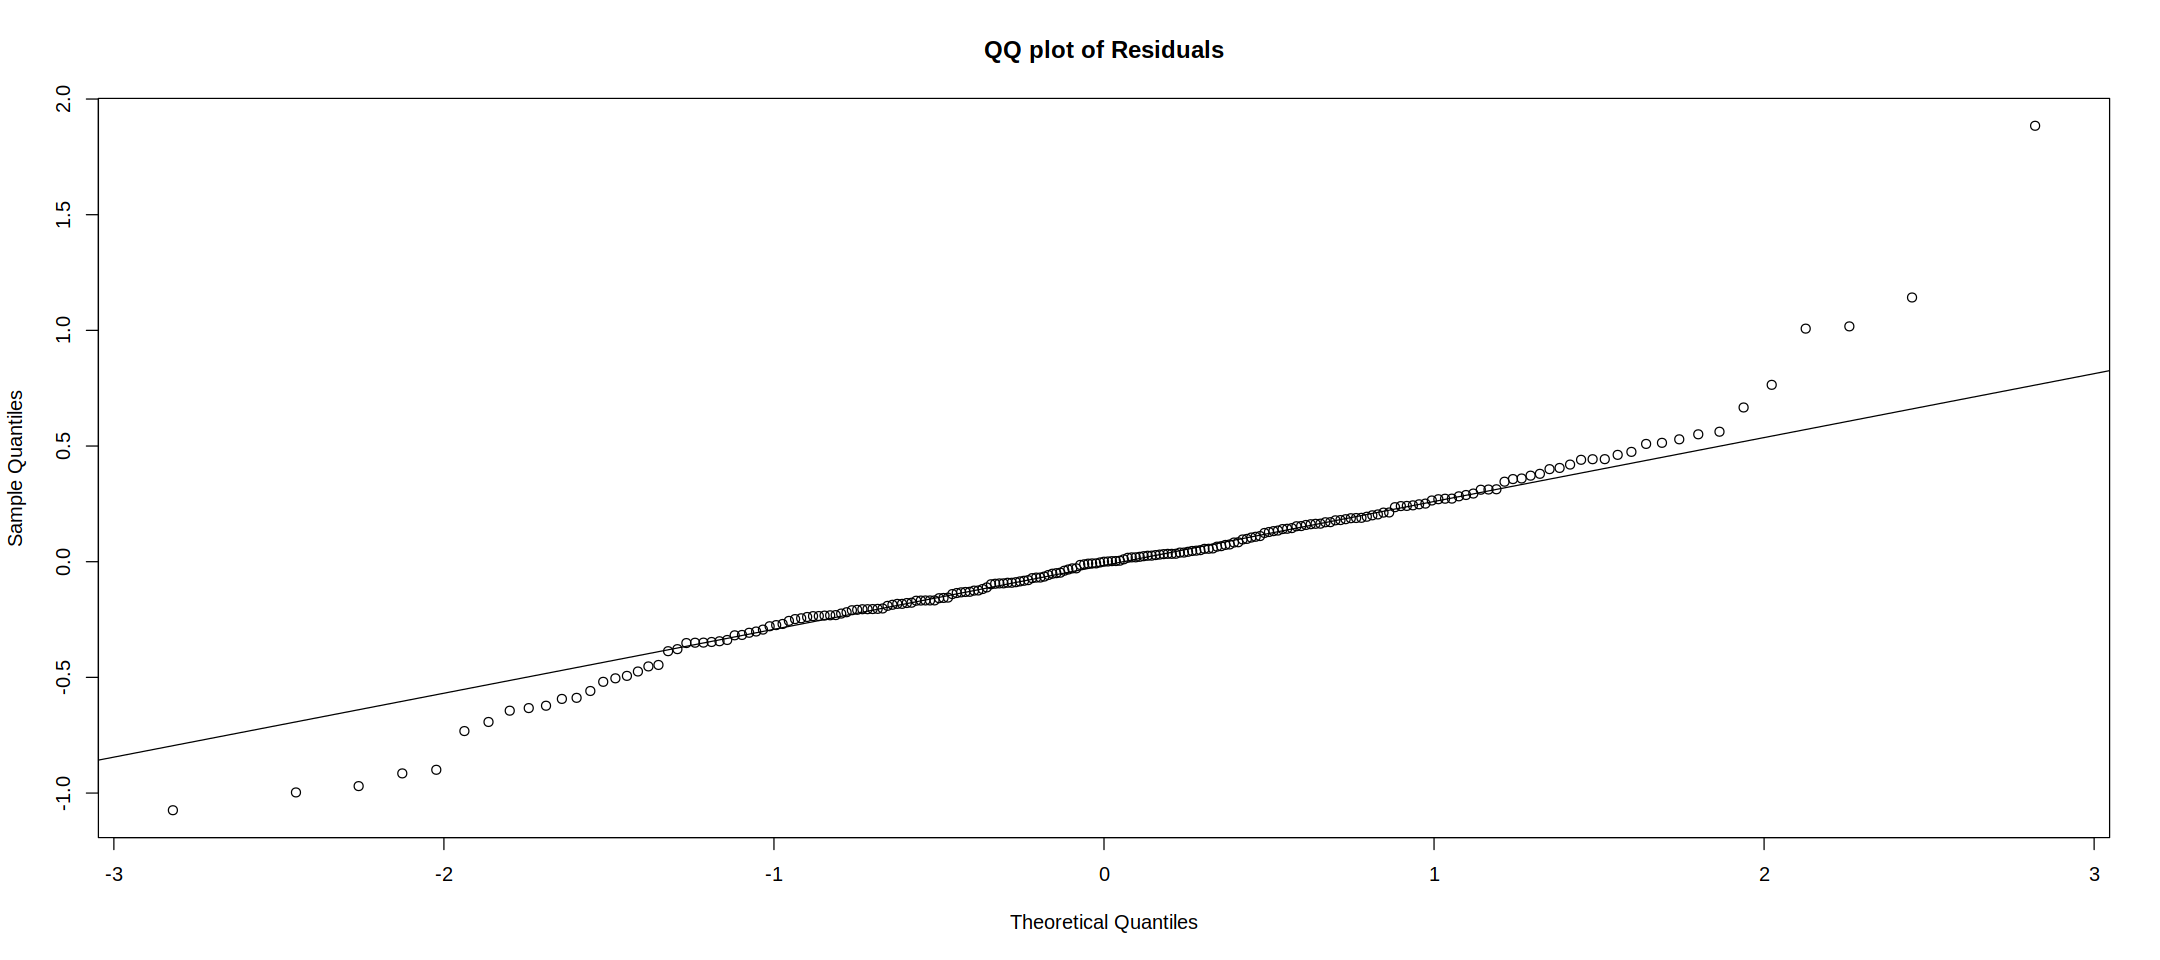

In [21]:
qqnorm(residuals(arima_model), main="QQ plot of Residuals")
qqline(residuals(arima_model))

Not quite promising results for normality based on the QQ plot.

In [22]:
shapiro.test(residuals(arima_model)) # normality


	Shapiro-Wilk normality test

data:  residuals(arima_model)
W = 0.93903, p-value = 1.111e-07


As expected, the **$p-value \leq 0.05$** indicates that we ought to reject the null hypothesis **$H_0$**. Thus, the residuals are not normally distributed.

#### Independence

In [23]:
Box.test(residuals(arima_model))


	Box-Pierce test

data:  residuals(arima_model)
X-squared = 0.11684, df = 1, p-value = 0.7325


**$p-value \gt 0.05$**, we fail to reject the null hypothesis which indicates that the data (residuals here) are independent. So, **$H_0$** is accepted, the residuals are independent enough.

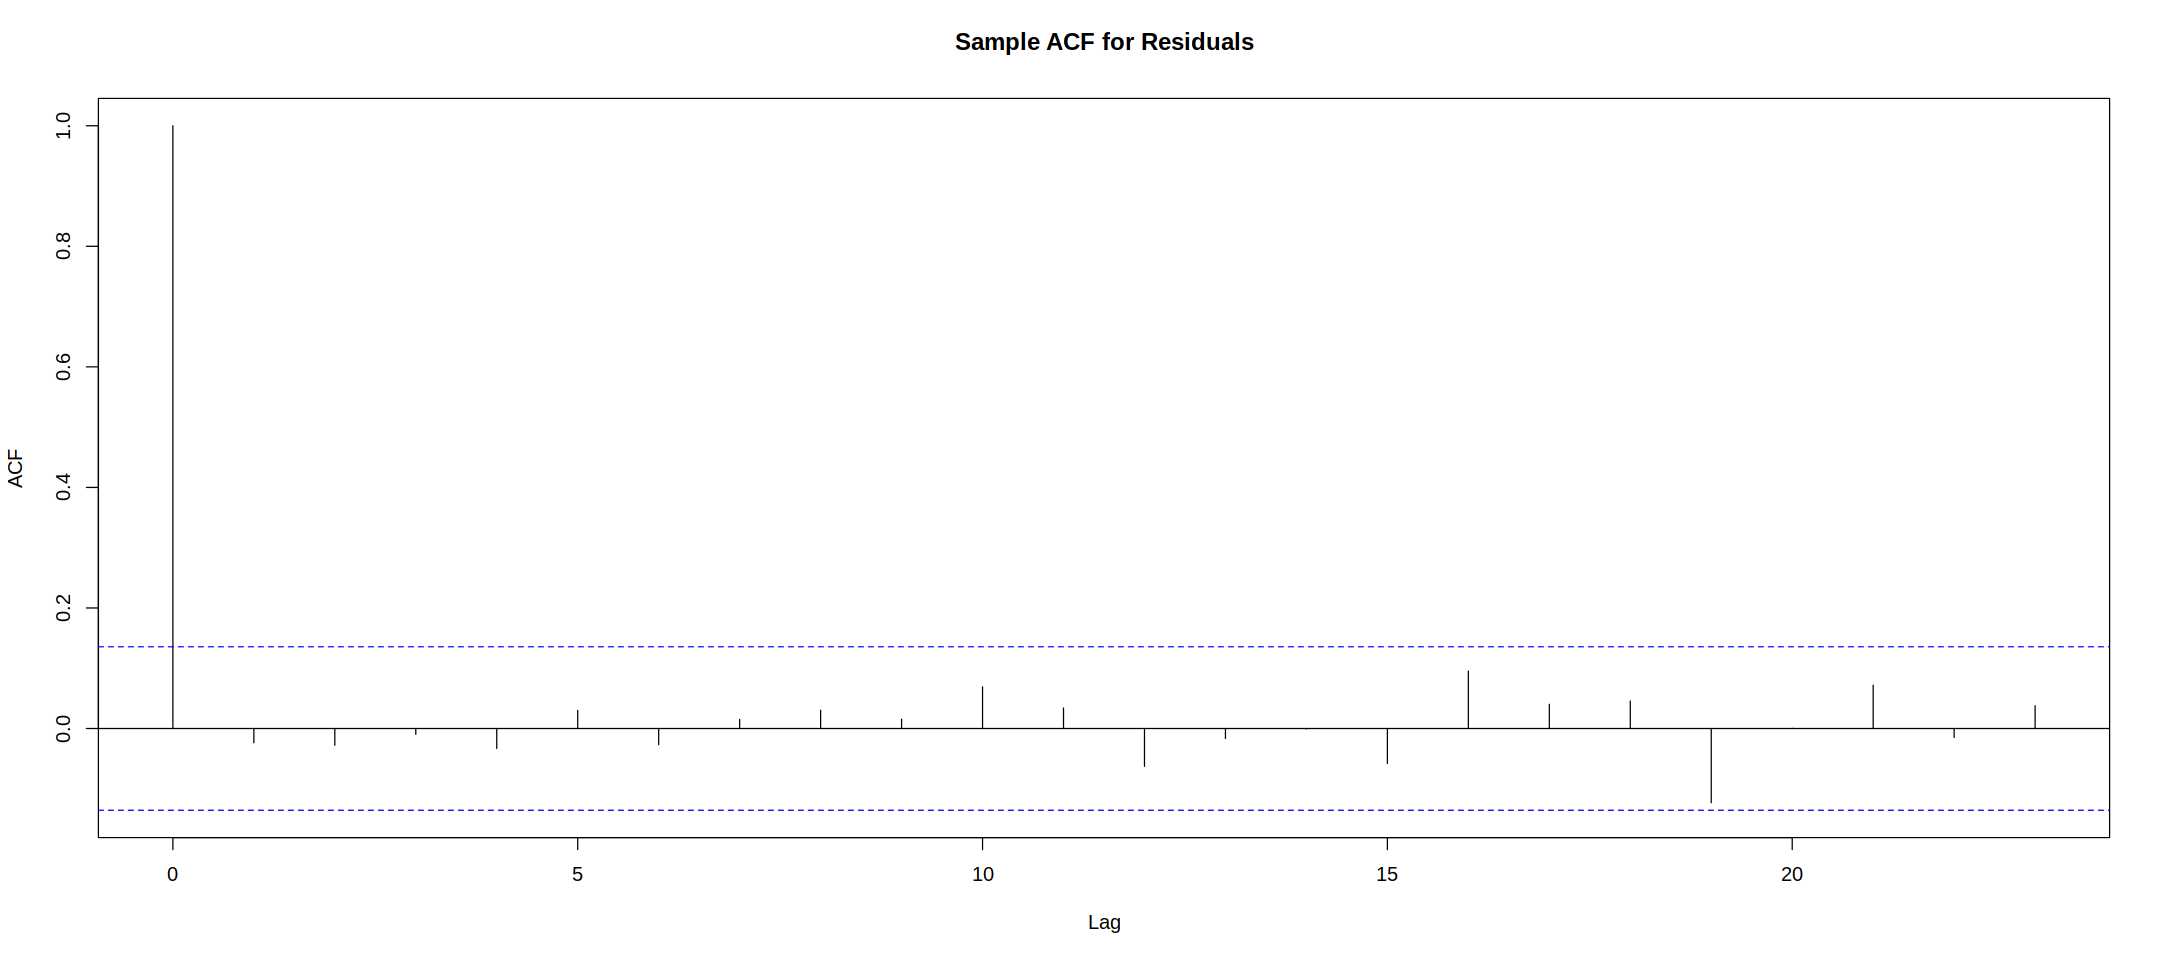

In [24]:
acf(residuals(arima_model), main='Sample ACF for Residuals')

The **ACF** confirms the independence of residuals.

#### **Future Predictions**

We reached the main aim of this study, to forecast future values of the occupancy rate. to do that, we will use the function

#### Predicting

In [25]:
# number of future forecasted values
future_horizon = 50

# predictions
predictions = forecast(arima_model, h = future_horizon)
predictions

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
210       2.966047 2.509698 3.422396 2.268122 3.663972
211       2.440118 1.974990 2.905245 1.728767 3.151469
212       2.565848 2.080119 3.051576 1.822990 3.308705
213       3.580808 3.068875 4.092742 2.797874 4.363743
214       2.744971 2.223857 3.266085 1.947995 3.541947
215       3.242957 2.720681 3.765232 2.444205 4.041708
216       3.148333 2.602627 3.694039 2.313748 3.982918
217       2.871751 2.268187 3.475315 1.948680 3.794822
218       2.479045 1.867865 3.090224 1.544327 3.413762
219       2.563983 1.949653 3.178312 1.624447 3.503519
220       3.485761 2.860140 4.111381 2.528957 4.442565
221       2.716706 2.089450 3.343963 1.757401 3.676012
222       3.193549 2.565904 3.821194 2.233649 4.153449
223       3.028050 2.389742 3.666358 2.051842 4.004258
224       2.790081 2.121047 3.459115 1.766882 3.813280
225       2.538306 1.866653 3.209958 1.511102 3.565509
226       2.566401 1.893922 3.238880 1.537934 3.594869
227       

#### Analytical Evaluation

there is no *best* metric for evaluating the model as the most appropriate choice depends on the specific characteristics of the data and aim of the study. For the study of forecasting the occupancy rates to lower the costs and increase the profits, using **Mean Squared Error (MSE)** is sufficient.

In order to calculate the **MSE** of the test, we take the first **23** of the predicted values. Because, our model was built with the train data. And then using it, we forecasted **50** future values, the first **23** of them are of the test.

In [26]:
# train mse
train_mse = mean((residuals(arima_model)^2))
# test mse (first 24 predictions)
test_mse = mean((predictions$mean[1:23] - test)^2) 

print(paste('MSE for train data:', train_mse))
print(paste('MSE for test data:', test_mse))

[1] "MSE for train data: 0.125665791742878"
[1] "MSE for test data: 0.0700146423281426"


#### Graphical Evaluation

In this evaluatio part, we will simply plot the test data and the forecasted values (test and extra values as well) together in the same plot:

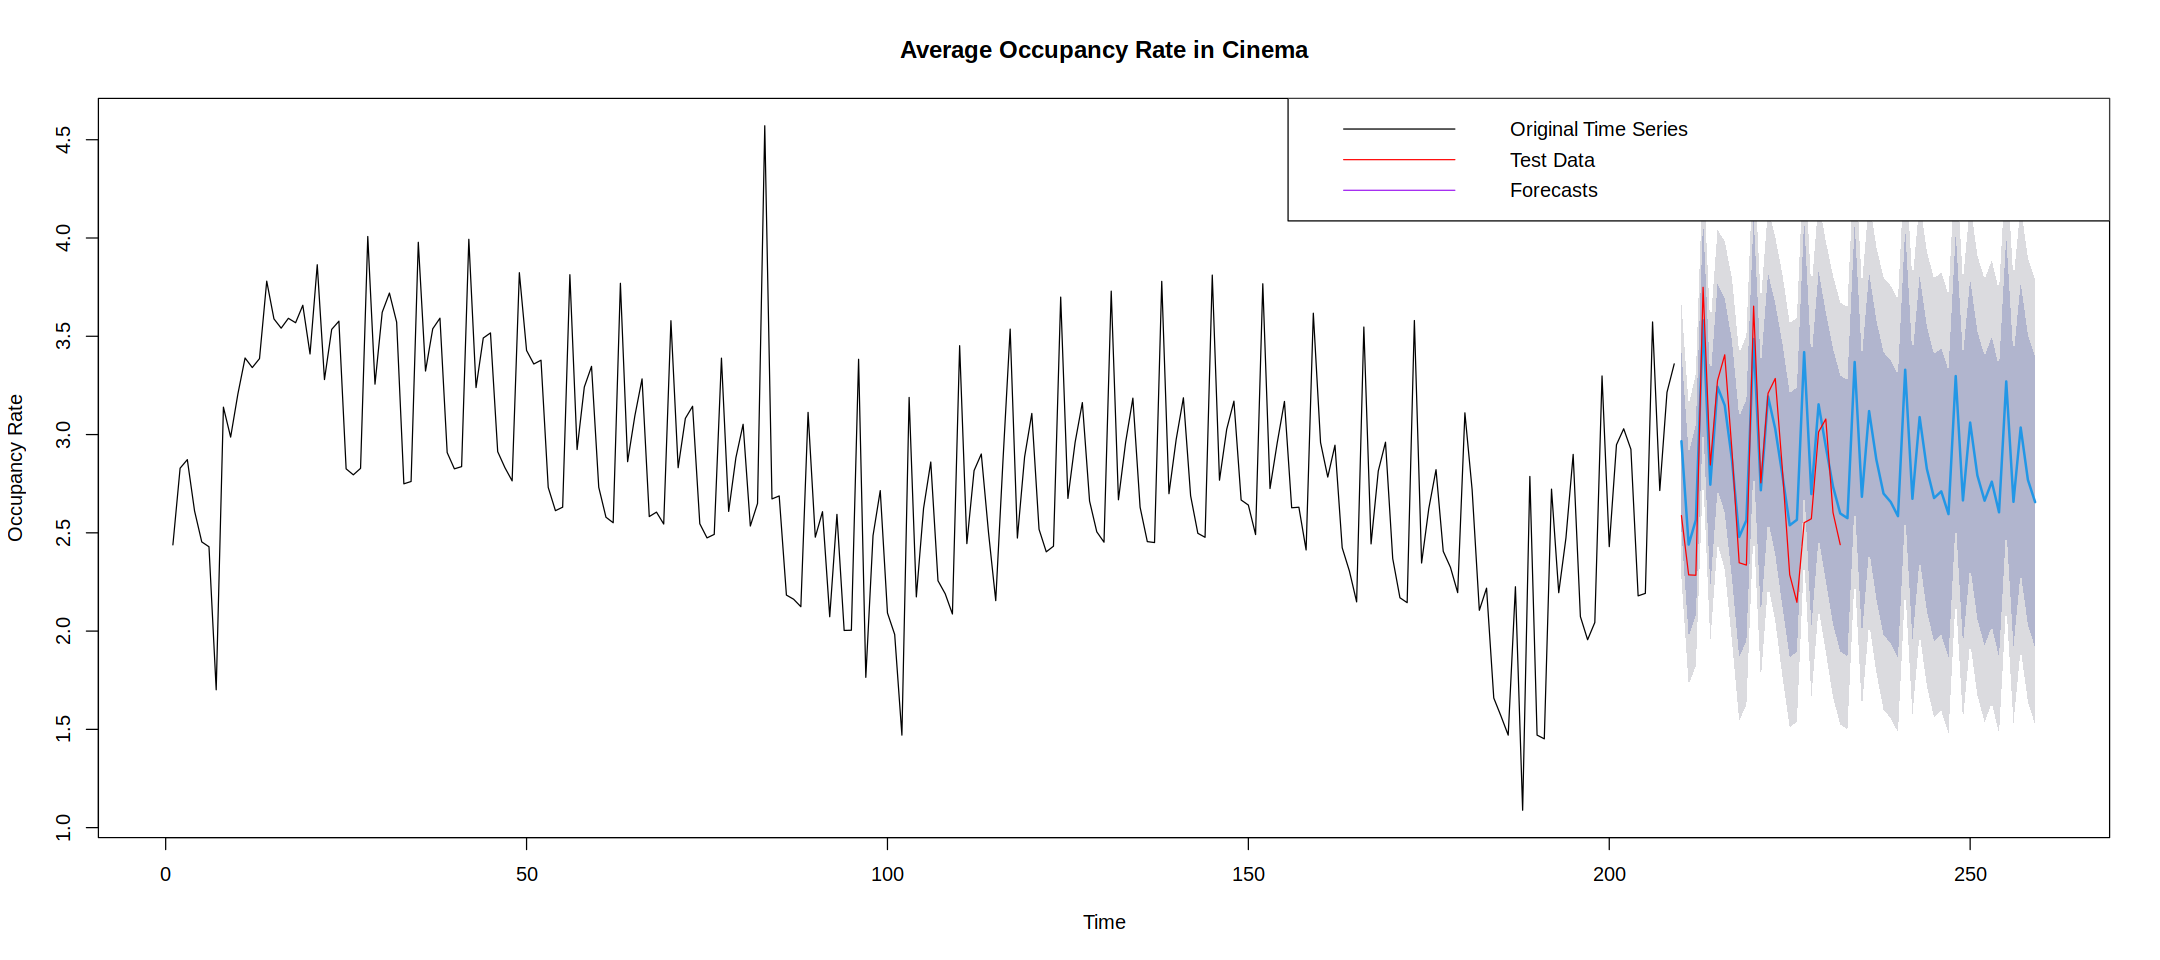

In [27]:
# plotting the original time series and the combined series
plot(predictions, 
     type ='l', xlab='Time', ylab ='Occupancy Rate', 
     main = 'Average Occupancy Rate in Cinema')
lines(test, col = "red")
legend("topright", legend=c('Original Time Series', 'Test Data', 'Forecasts'), col=c('black', 'red', 'purple'), lty=1)

The results are as follows:
* the black line is the original train data
* the red line is the original test data
* the violet line is the predictions

Note that in order to find the exact original value of a forecasted one, we use the exponent function **$exp()$** to re-scale the prediction back to its original scale. This is due to stabilizing the data using the logarithm **$log()$** with **Boxcox** transformation.  
For example, we will re-scale the predictions to their original scale back:

In [28]:
# re-scale the predictions:
predictions$mean = exp(predictions$mean)
predictions

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
210       19.41502 2.509698 3.422396 2.268122 3.663972
211       11.47439 1.974990 2.905245 1.728767 3.151469
212       13.01169 2.080119 3.051576 1.822990 3.308705
213       35.90255 3.068875 4.092742 2.797874 4.363743
214       15.56416 2.223857 3.266085 1.947995 3.541947
215       25.60933 2.720681 3.765232 2.444205 4.041708
216       23.29719 2.602627 3.694039 2.313748 3.982918
217       17.66793 2.268187 3.475315 1.948680 3.794822
218       11.92986 1.867865 3.090224 1.544327 3.413762
219       12.98744 1.949653 3.178312 1.624447 3.503519
220       32.64725 2.860140 4.111381 2.528957 4.442565
221       15.13041 2.089450 3.343963 1.757401 3.676012
222       24.37478 2.565904 3.821194 2.233649 4.153449
223       20.65692 2.389742 3.666358 2.051842 4.004258
224       16.28234 2.121047 3.459115 1.766882 3.813280
225       12.65820 1.866653 3.209958 1.511102 3.565509
226       13.01889 1.893922 3.238880 1.537934 3.594869
227       

The column **Point Forecast** represents the original scale of occupancy rate (percentage) of the forecasted values.

### **Discussion & Conclusion**

The **$ARIMA(8, 1, 7)$** model trained on historical occupancy rate data demonstrated quite promising results and performance in forecasting future values of attendance. However, due to the nature of the data, it is still cannot capture all the patterns in it.  
The choice of the specific parameters of **$ARIMA(8, 1, 7)$** went through a process of trial after indicating the set of potential combinations using **armasubsets** and **BIC** measures.
Visualizations of the residuals and the predictions confirmed the model's ability to track seasonal trends.  
The ability to accurately forecast occupancy rates empowers cinema halls to make informed decisions regarding staffing levels, management and pricing strategies. They can optimize costs, especially during low-demand periods.  
There are opportunities for continuous refinement and enhancement of the model by feeding it with extra data sources and other patterns.  
Overall, this study demonstrates the potential of **$ARIMA$** models for forecasting cinema occupancy rates. By implementing these forecasts in business planning, cinemas can optimize resource allocation, reduce costs, and ultimately increase profits.  